In [29]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier


In [4]:
data=pd.read_csv("./term-deposit-marketing-2020.csv")


In [4]:
data['y'].value_counts()

y
no     37104
yes     2896
Name: count, dtype: int64

Out of 40K customers contacted in the marketing campaign, 37104 customers (93%) did not subscribe and 2896 customers (7%) subscribed to a term-deposit. There is a class imbalance. 

In [6]:
# List of categorical variables
categorical_features = ['job', 'marital', 'contact', 'month', 'education']

# Loop through each categorical variable and print the count of each category
for feature in categorical_features:
    print(f'Category counts for {feature}:')
    print(data[feature].value_counts())
    print('-' * 40)  # Separator for readability

binary_features=['default','housing','loan']

# Loop through each categorical variable and print the count of each category
for feature in binary_features:
    print(f'Category counts for {feature}:')
    print(data[feature].value_counts())
    print('-' * 40)  # Separator for readability


Category counts for job:
job
blue-collar      9383
management       8166
technician       6852
admin            4483
services         3910
retired          1437
self-employed    1414
entrepreneur     1405
unemployed       1104
housemaid        1087
student           524
unknown           235
Name: count, dtype: int64
----------------------------------------
Category counts for marital:
marital
married     24386
single      10889
divorced     4725
Name: count, dtype: int64
----------------------------------------
Category counts for contact:
contact
cellular     24914
unknown      12765
telephone     2321
Name: count, dtype: int64
----------------------------------------
Category counts for month:
month
may    13532
jul     6380
aug     5215
jun     4734
nov     3598
apr     2718
feb     2296
jan     1176
mar      258
oct       80
dec       13
Name: count, dtype: int64
----------------------------------------
Category counts for education:
education
secondary    20993
tertiary     11206

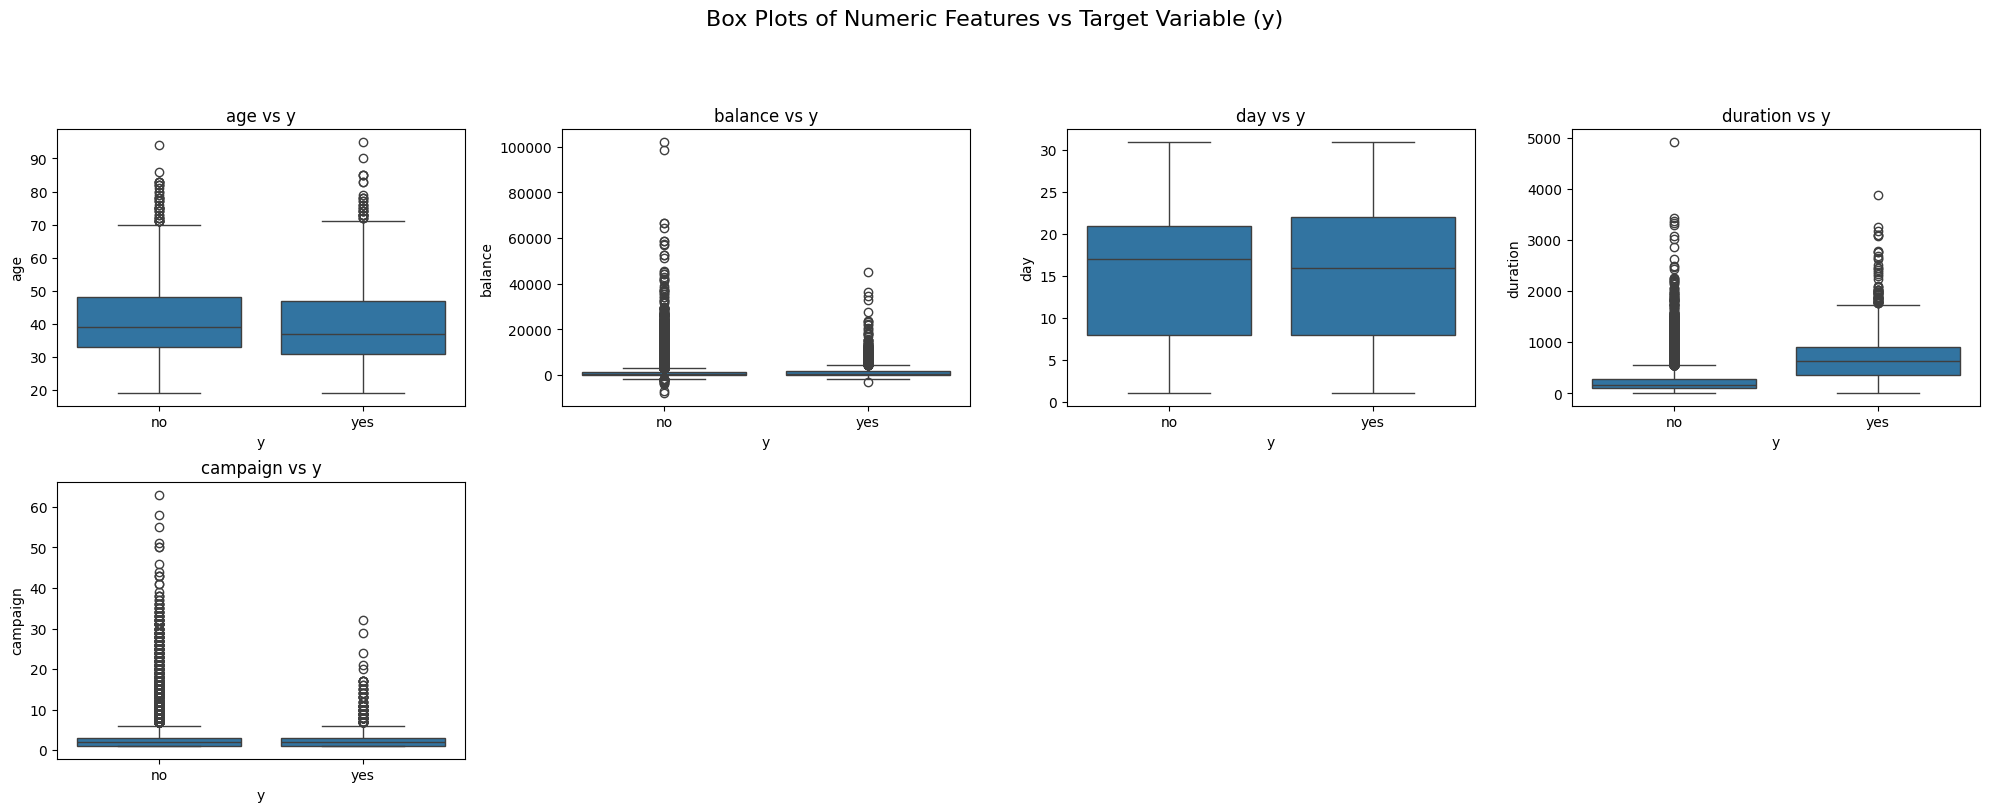

In [16]:
X = data.drop(['y'],axis=1)
y= data['y']
features=X.columns

# List of categorical features to exclude from box plots
categorical_features = ['job', 'marital', 'education', 'contact', 'month']
binary_features=['default','housing','loan']

# Filter out categorical features to get only numeric and binary features
numeric_features = [feature for feature in features if feature not in categorical_features and feature not in binary_features]

# Create a grid of subplots (4 rows x 4 columns)
fig, axes = plt.subplots(4, 4, figsize=(20, 15))
fig.suptitle('Box Plots of Numeric Features vs Target Variable (y)', fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each feature and plot
for i, feature in enumerate(numeric_features):
    sns.boxplot(x='y', y=feature, data=data, ax=axes[i])
    axes[i].set_title(f'{feature} vs y')

# Remove any empty subplots (there will be 3 empty plots)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust top for the suptitle
plt.show()


The data has lots of outliers. Let's remove the outliers then look for patterns.

In [17]:
# Function to remove outliers using IQR
def remove_outliers(df, features):
    df_no_outliers = df.copy()
    for feature in features:
        # Calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = df_no_outliers[feature].quantile(0.25)
        Q3 = df_no_outliers[feature].quantile(0.75)
        IQR = Q3 - Q1
        
        # Calculate lower and upper bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filter out the outliers
        df_no_outliers = df_no_outliers[(df_no_outliers[feature] >= lower_bound) & (df_no_outliers[feature] <= upper_bound)]
        
    return df_no_outliers

# Remove outliers from continuous features
data_cleaned = remove_outliers(data, numeric_features)

# Display the cleaned data
print(data_cleaned.describe())


                age       balance           day      duration      campaign
count  30467.000000  30467.000000  30467.000000  30467.000000  30467.000000
mean      40.242196    571.955493     15.640759    201.956248      2.180753
std        9.469559    780.794935      8.279490    136.049736      1.338638
min       19.000000  -1818.000000      1.000000      0.000000      1.000000
25%       33.000000     30.000000      8.000000    100.000000      1.000000
50%       39.000000    311.000000     16.000000    167.000000      2.000000
75%       47.000000    878.000000     21.000000    272.000000      3.000000
max       70.000000   3207.000000     31.000000    626.000000      6.000000


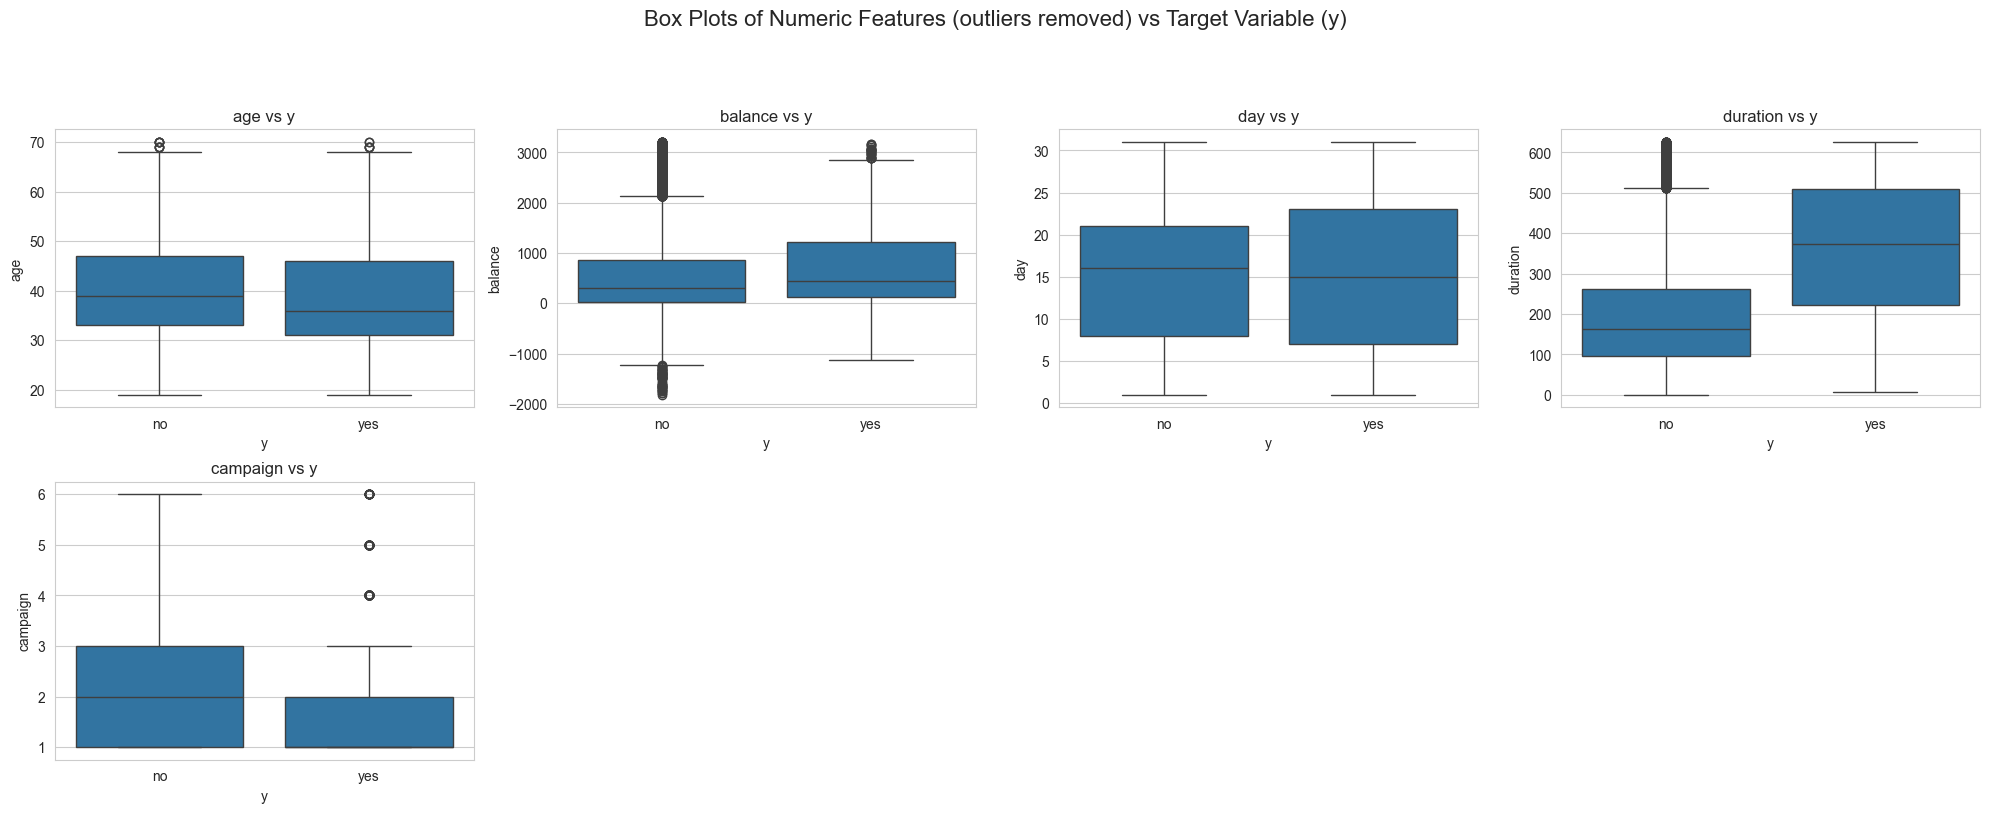

In [67]:
# Create a grid of subplots (4 rows x 4 columns)
fig, axes = plt.subplots(4, 4, figsize=(20, 15))
fig.suptitle('Box Plots of Numeric Features (outliers removed) vs Target Variable (y)', fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each feature and plot
for i, feature in enumerate(numeric_features):
    sns.boxplot(x='y', y=feature, data=data_cleaned, ax=axes[i])
    axes[i].set_title(f'{feature} vs y')

# Remove any empty subplots (there will be 3 empty plots)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust top for the suptitle
plt.show()

Rough Pattern: Younger people, with more money in their bank accounts, contacted during the first half of the month, who speak for longer, tend to subscribe.

<br>
All the numeric features age, balance, day, duration, campaign seem to have predictive power...they have an effect on the outcome.

In [148]:
data_cleaned['y'].value_counts()

y
no     29327
yes     1140
Name: count, dtype: int64

Out of the original 40,000 records, roughly 10K are outliers. With the outliers removed 96% are not subscribers and 4% are subscribers. 

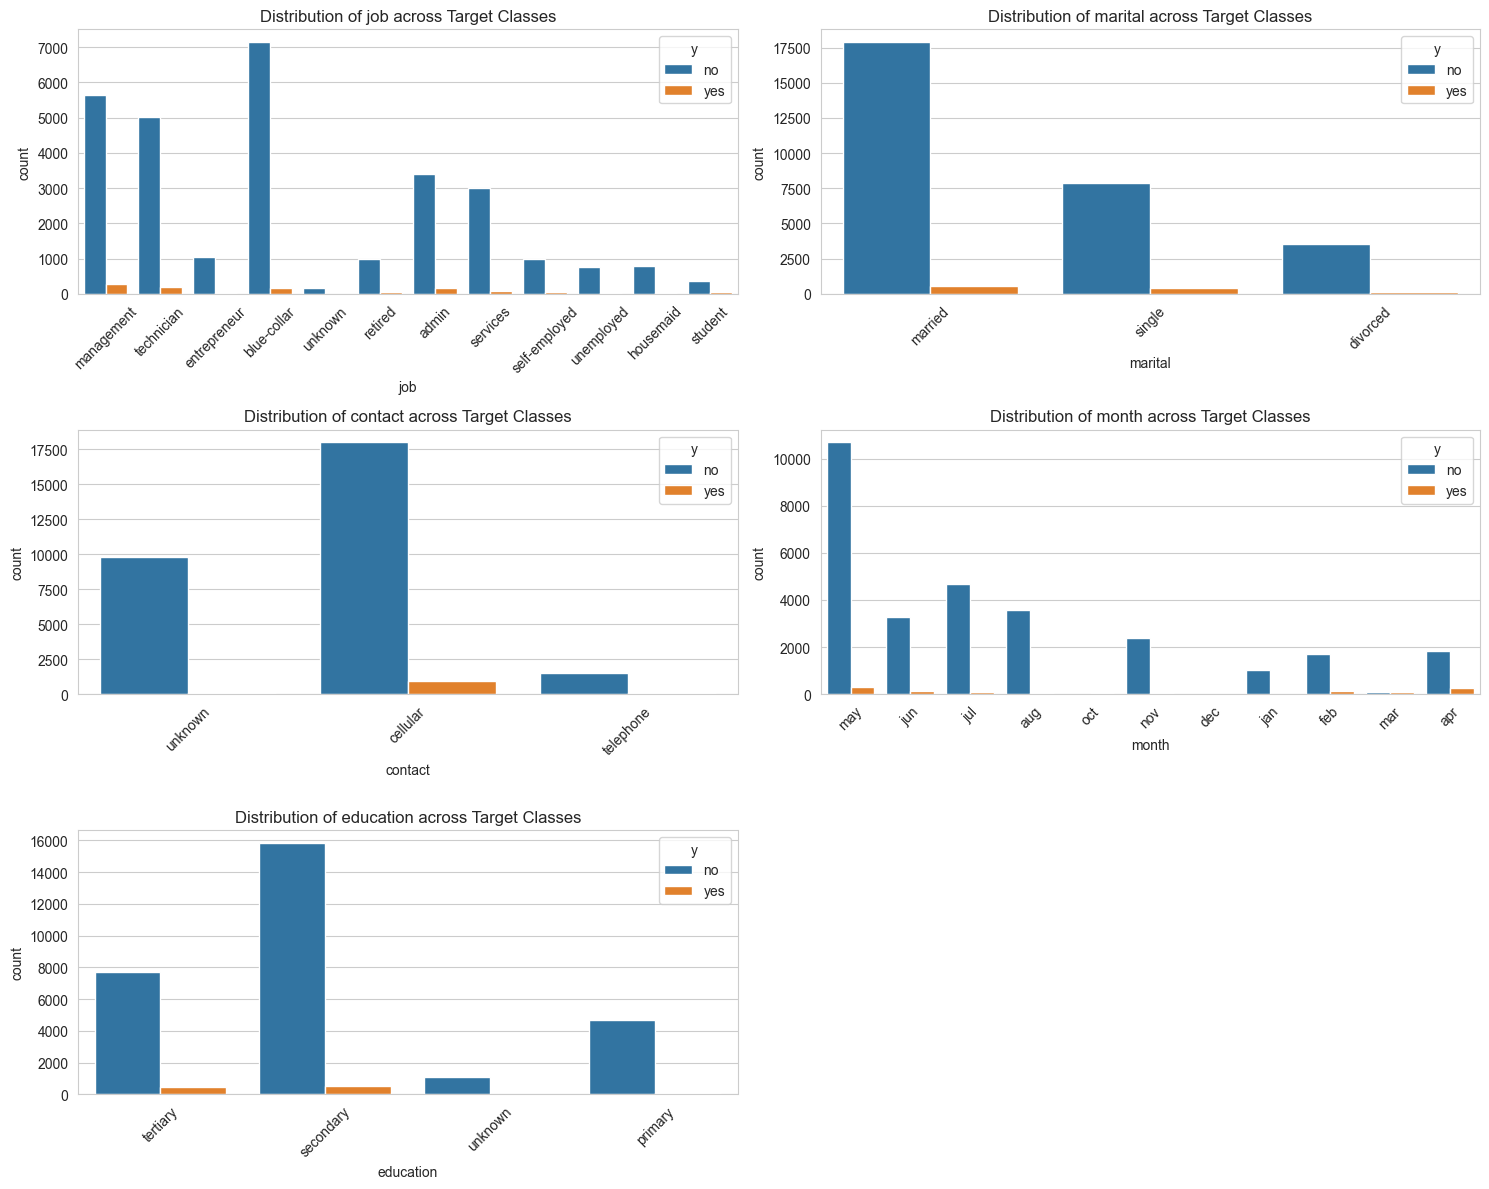

In [70]:
# Set up the plot
plt.figure(figsize=(15, 12))  # Adjust the figure size as necessary

# Loop through each categorical feature and create a bar chart
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(3, 2, i)  # 3 rows, 2 columns layout
    sns.countplot(x=feature, hue='y', data=data_cleaned)  # hue='y' adds the target class to the plot
    plt.title(f'Distribution of {feature} across Target Classes')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

Pattern: Job = Management, technician, blue collar, admin, services. Married or single people not divorced. Contacted by cellular in the months of feb through july whose education is secondary or tertiary.  



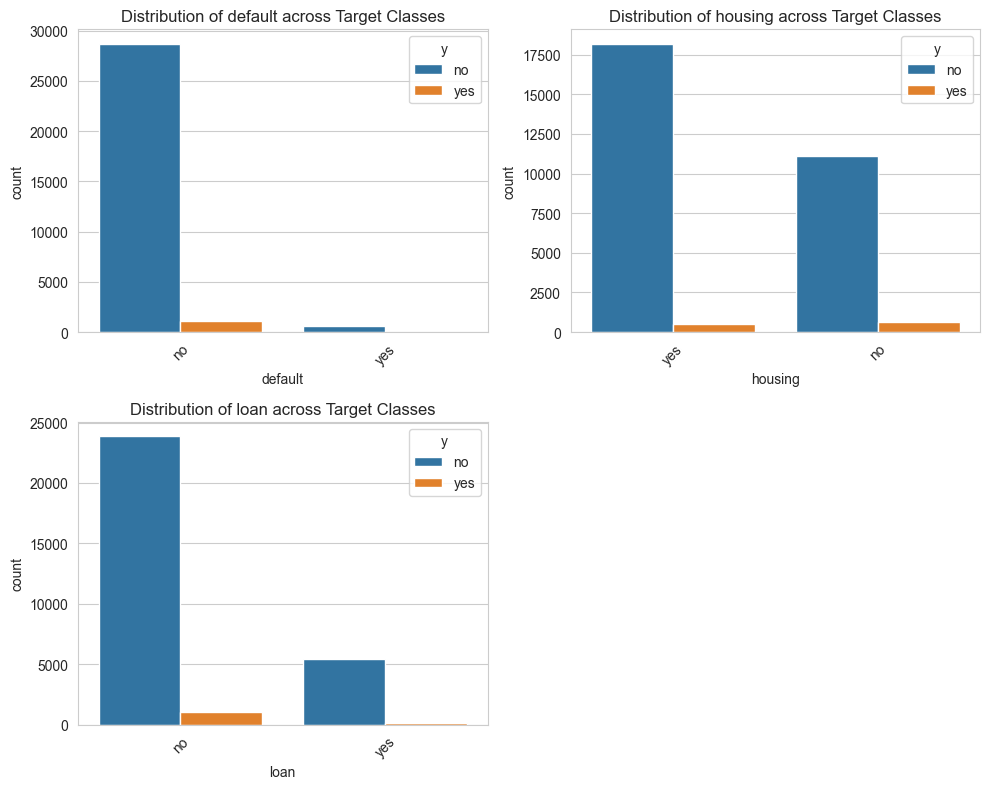

In [72]:
# Set up the plot
plt.figure(figsize=(10, 8))  # Adjust the figure size as necessary

# Loop through each binary feature and create a bar chart
for i, feature in enumerate(binary_features, 1):
    plt.subplot(2, 2, i)  # 2 rows, 2 columns layout (adjust if needed)
    sns.countplot(x=feature, hue='y', data=data_cleaned)  # hue='y' adds the target class to the plot
    plt.title(f'Distribution of {feature} across Target Classes')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

Pattern: Those who have not defaulted and don't have a loan. 

Now let's try to filter the data based on these eye-balling observations. 

In [84]:
# Define filter conditions for each feature
job_filter = ~data_cleaned['job'].isin(['housemaid', 'unemployed', 'entrepreneur', 'unknown'])  # Exclude these categories
marital_filter = data_cleaned['marital'].isin(['married', 'single'])  # Exclude 'divorced'
contact_filter = data_cleaned['contact'] == 'cellular'
month_filter = data_cleaned['month'].isin(['feb', 'mar', 'apr', 'may', 'jun', 'jul'])  # Feb to July
education_filter = data_cleaned['education'].isin(['secondary', 'tertiary'])
default_filter = data_cleaned['default'] == 'no'
loan_filter = data_cleaned['loan'] == 'no'

# Apply all filters together
filtered_data = data_cleaned[job_filter & contact_filter & month_filter & education_filter & default_filter]

# Count the number of records that match the filter
count = filtered_data.shape[0]

# Display the count
print(f'Total records that match the filter: {count}')

Total records that match the filter: 9217


Let's see how many subscribers are lost.

In [19]:
subscribed = data_cleaned[data_cleaned['y']=='yes']
subscribed.shape

(1140, 14)

In [85]:
# Apply all filters together
subscribed_filtered_data = subscribed[job_filter & contact_filter & month_filter & education_filter & default_filter]

# Count the number of records that match the filter
count_filtered_subscribers = subscribed_filtered_data.shape[0]

# Display the count
print(f'Total subscribers that match the filter: {count_filtered_subscribers}')

Total subscribers that match the filter: 700


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_18332\1544928984.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subscribed_filtered_data = subscribed[job_filter & contact_filter & month_filter & education_filter & default_filter]


In [105]:
# Prepare a list to hold the counts for all sub-categories
all_counts = []

# Loop through each categorical feature
for feature in categorical_features:
    # Get the unique sub-categories in the feature
    sub_categories = data_cleaned[feature].unique()
    
    # Loop through each sub-category in the feature
    for sub_category in sub_categories:
        # Create a subset of the data for the sub-category
        subset_data = data_cleaned[data_cleaned[feature] == sub_category]
        
        # Count occurrences of target variable
        count_data = subset_data['y'].value_counts()
        
        # Append counts to the list
        all_counts.append({
            'feature': feature,
            'sub_category': sub_category,
            'yes': count_data.get('yes', 0),
            'no': count_data.get('no', 0)
        })

# Create a DataFrame from the counts
counts_df = pd.DataFrame(all_counts)

# Group by feature and sub_category and sum the counts
grouped_counts_df = counts_df.groupby(['feature', 'sub_category'], as_index=False).sum()

# Calculate proportion of 'yes' to 'no'
grouped_counts_df['proportion'] = grouped_counts_df['yes'] / (grouped_counts_df['yes'] + grouped_counts_df['no'])

# Sort the DataFrame by count of 'yes' in ascending order
sorted_by_yes_df = grouped_counts_df.sort_values(by='yes', ascending=True)

# Print the sorted DataFrame ordered by yes count
print("Sorted by Yes Count:")
print(sorted_by_yes_df[['feature', 'sub_category', 'yes', 'no', 'proportion']])

# Sort the DataFrame by proportion in ascending order
sorted_by_proportion_df = grouped_counts_df.sort_values(by='proportion', ascending=True)

# Print the sorted DataFrame ordered by proportion
print("\nSorted by Proportion:")
print(sorted_by_proportion_df[['feature', 'sub_category', 'yes', 'no', 'proportion']])

Sorted by Yes Count:
      feature   sub_category  yes     no  proportion
24      month            dec    1     11    0.083333
26      month            jan    5   1041    0.004780
18        job        unknown    7    154    0.043478
10        job      housemaid   20    794    0.024570
9         job   entrepreneur   28   1040    0.026217
32      month            oct   29     22    0.568627
6   education        unknown   32   1087    0.028597
17        job     unemployed   38    776    0.046683
13        job  self-employed   40    992    0.038760
15        job        student   49    364    0.118644
12        job        retired   49    987    0.047297
31      month            nov   62   2373    0.025462
1     contact      telephone   68   1533    0.042473
23      month            aug   71   3573    0.019484
14        job       services   83   3007    0.026861
27      month            jul   87   4696    0.018189
29      month            mar   88     98    0.473118
3   education        prim

In [100]:
# Define the conditions for removal based on the identified candidates
conditions_to_remove = (
    (data_cleaned['month'] == 'jan') |
    (data_cleaned['job'] == 'unknown') |
    (data_cleaned['job'] == 'housemaid') |
    (data_cleaned['job'] == 'entrepreneur') |
    (data_cleaned['job'] == 'unemployed') |
    (data_cleaned['job'] == 'student')
)

# Filter the dataset to keep only the rows that do not meet the removal conditions
data_filtered = data_cleaned[~conditions_to_remove]

# Display the shape of the original and filtered datasets
print("Original dataset shape:", data_cleaned.shape)
print("Filtered dataset shape:", data_filtered.shape)
# Apply all filters together
subscribed_filtered_data = subscribed[~conditions_to_remove]

# Display the shape of the original and filtered datasets
print("Original subscribers shape:", subscribed.shape)
print("Filtered dataset shape:", subscribed_filtered_data.shape)


Original dataset shape: (30467, 14)
Filtered dataset shape: (26311, 14)
Original subscribers shape: (1140, 14)
Filtered dataset shape: (994, 14)


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_18332\92691485.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subscribed_filtered_data = subscribed[~conditions_to_remove]


In [101]:
# Prepare a list to hold the counts for all sub-categories
binary_counts = []

# Loop through each binary feature
for feature in binary_features:
    # Get the unique sub-categories in the feature
    sub_categories = data_cleaned[feature].unique()
    
    # Loop through each sub-category in the feature
    for sub_category in sub_categories:
        # Create a subset of the data for the sub-category
        subset_data = data_cleaned[data_cleaned[feature] == sub_category]
        
        # Count occurrences of target variable
        count_data = subset_data['y'].value_counts()
        
        # Append counts to the list
        binary_counts.append({
            'feature': feature,
            'sub_category': sub_category,
            'yes': count_data.get('yes', 0),
            'no': count_data.get('no', 0)
        })

# Create a DataFrame from the counts
binary_counts_df = pd.DataFrame(binary_counts)

# Calculate proportion of 'yes' to 'no'
binary_counts_df['proportion'] = binary_counts_df['yes'] / (binary_counts_df['yes'] + binary_counts_df['no'])

# Sort the DataFrame by the count of 'yes' in ascending order
sorted_binary_counts_df = binary_counts_df.sort_values(by='yes', ascending=True)

# Print the sorted DataFrame with relevant columns
print(sorted_binary_counts_df[['feature', 'sub_category', 'yes', 'no', 'proportion']])

   feature sub_category   yes     no  proportion
1  default          yes    22    646    0.032934
5     loan          yes   122   5465    0.021836
2  housing          yes   493  18191    0.026386
3  housing           no   647  11136    0.054910
4     loan           no  1018  23862    0.040916
0  default           no  1118  28681    0.037518


<h1> Findings </h1>

1) By not calling in the month of January and by not calling those who work in jobs in unknown, housemaid, entrepreneur, unemployed, student we can reduce 4156 out of 30467 calls (13.6%) while losing 146 out of 1140 (12.8%) subscribers. 

2) By removing contact=unknown you can reduce 9789 calls (32%) while losing only 117 (10%) subscribers. 

3) By removing month=jan you can reduce the calls by 1041 (3.4%) while losing 5 subscribers (0.4%). 

4) By removing loan=yes can reduce 5465 calls (18%) while losing 122 subscribers (10.7%). 

5) By removing both 2 and 3 can reduce 10830 calls (35.5%) while losing 122 subscribers (10.7%)

<h1> First Layer Conclusion </h1>

<b> Don't call in the month of January and don't call those who's contact type is uknown </b>

Now lets see the box plots of the numeric features with these records removed

In [129]:
data_cleaned['y']

0         no
1         no
2         no
3         no
4         no
        ... 
39994     no
39995     no
39997    yes
39998     no
39999     no
Name: y, Length: 30467, dtype: object

In [20]:
# Define the conditions for removal based on the identified candidates
conditions_to_remove = (
    (data_cleaned['month'] == 'jan') |
    (data_cleaned['contact'] == 'unknown') 
)

# Filter the dataset to keep only the rows that do not meet the removal conditions
data_cleaned_filtered = data_cleaned[~conditions_to_remove]

# Display the shape of the original and filtered datasets
print("Original dataset shape:", data_cleaned.shape)
print("Filtered dataset shape:", data_cleaned_filtered.shape)
# Apply all filters together
subscribed_filtered_data = subscribed[~conditions_to_remove]

# Display the shape of the original and filtered datasets
print("Original subscribers shape:", subscribed.shape)
print("Filtered subscribers shape:", subscribed_filtered_data.shape)


Original dataset shape: (30467, 14)
Filtered dataset shape: (19515, 14)
Original subscribers shape: (1140, 14)
Filtered subscribers shape: (1018, 14)


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_2860\1504376205.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subscribed_filtered_data = subscribed[~conditions_to_remove]


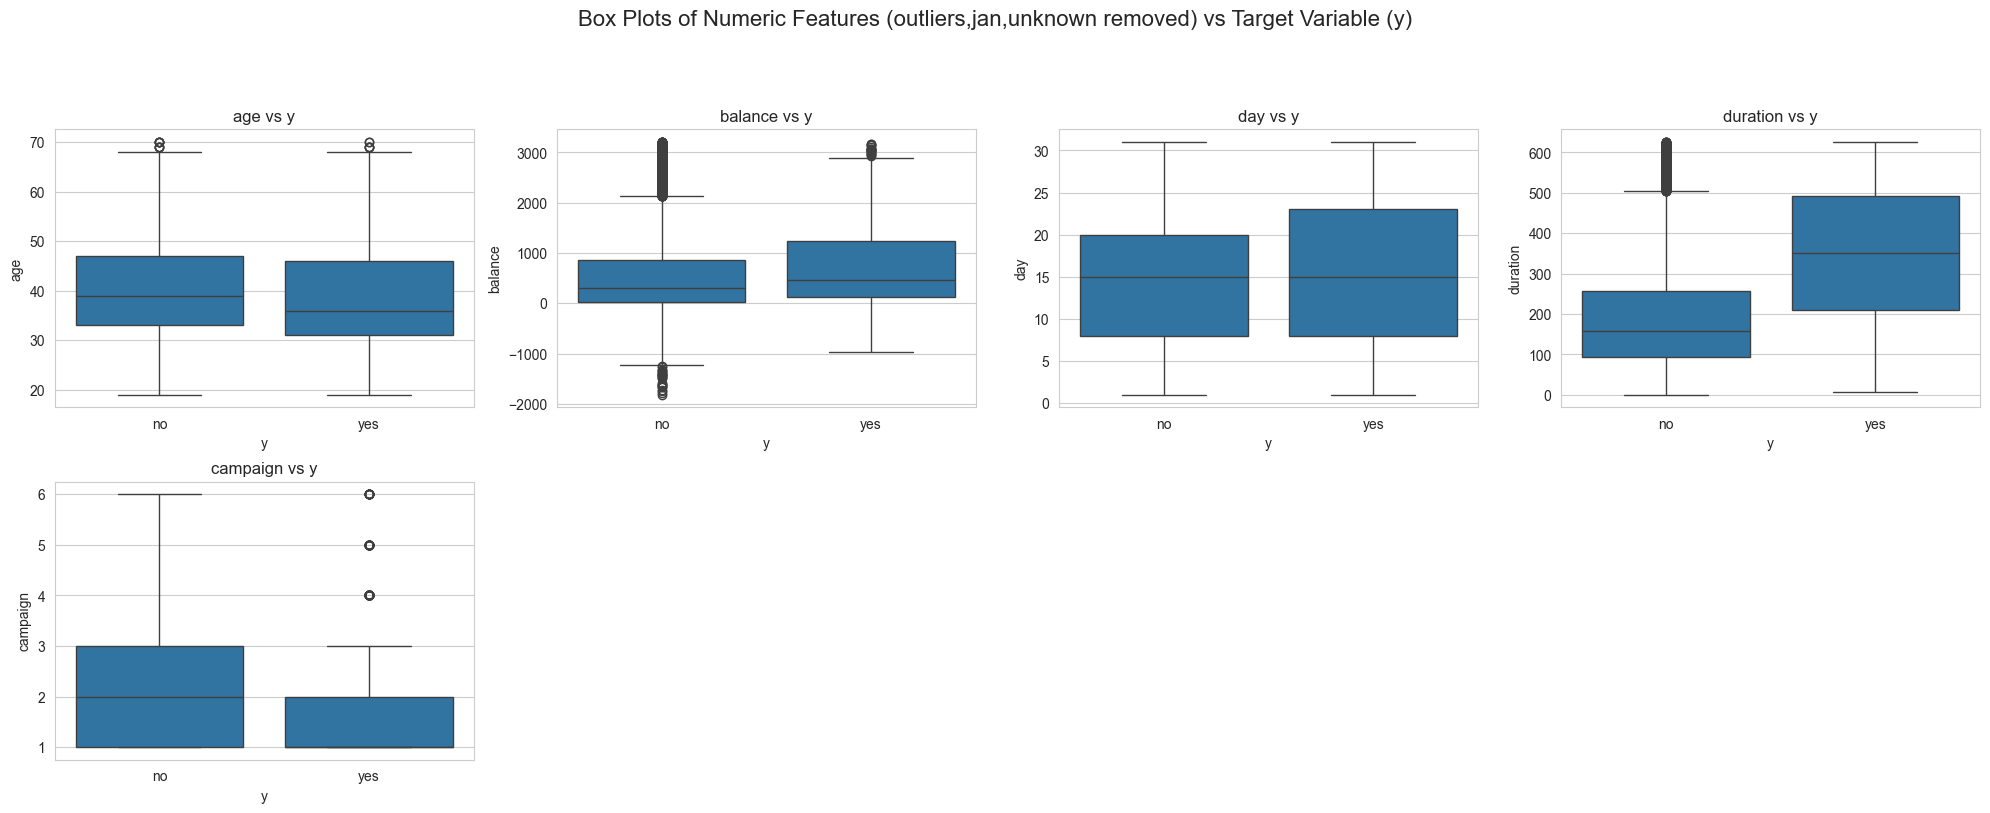

In [150]:
# Create a grid of subplots (4 rows x 4 columns)
fig, axes = plt.subplots(4, 4, figsize=(20, 15))
fig.suptitle('Box Plots of Numeric Features (outliers,jan,unknown removed) vs Target Variable (y)', fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each feature and plot
for i, feature in enumerate(numeric_features):
    sns.boxplot(x='y', y=feature, data=data_cleaned_filtered, ax=axes[i])
    axes[i].set_title(f'{feature} vs y')

# Remove any empty subplots (there will be 3 empty plots)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust top for the suptitle
plt.show()

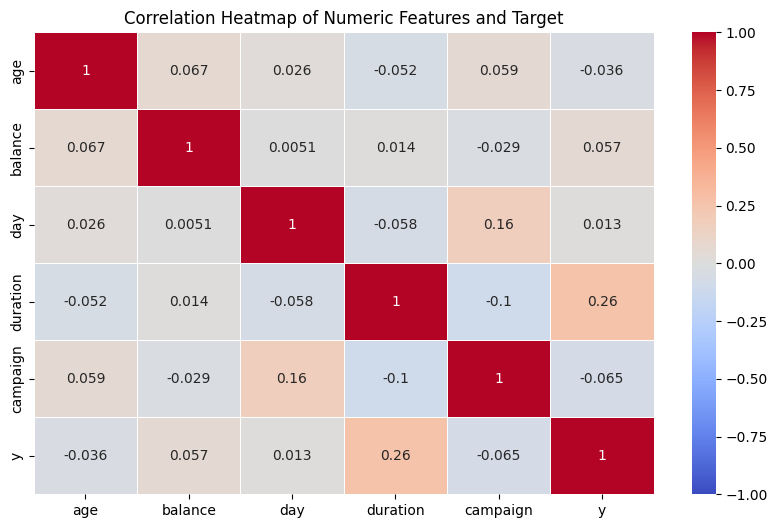

In [21]:
# Convert 'y' to binary values (1 for 'yes', 0 for 'no') and avoid SettingWithCopyWarning
data_cleaned_filtered.loc[:, 'y'] = data_cleaned_filtered['y'].map({'yes': 1, 'no': 0}).astype(int)

# Create a correlation matrix including 'y'
corr_matrix = data_cleaned_filtered[numeric_features + ['y']].corr()

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Heatmap of Numeric Features and Target')
plt.show()


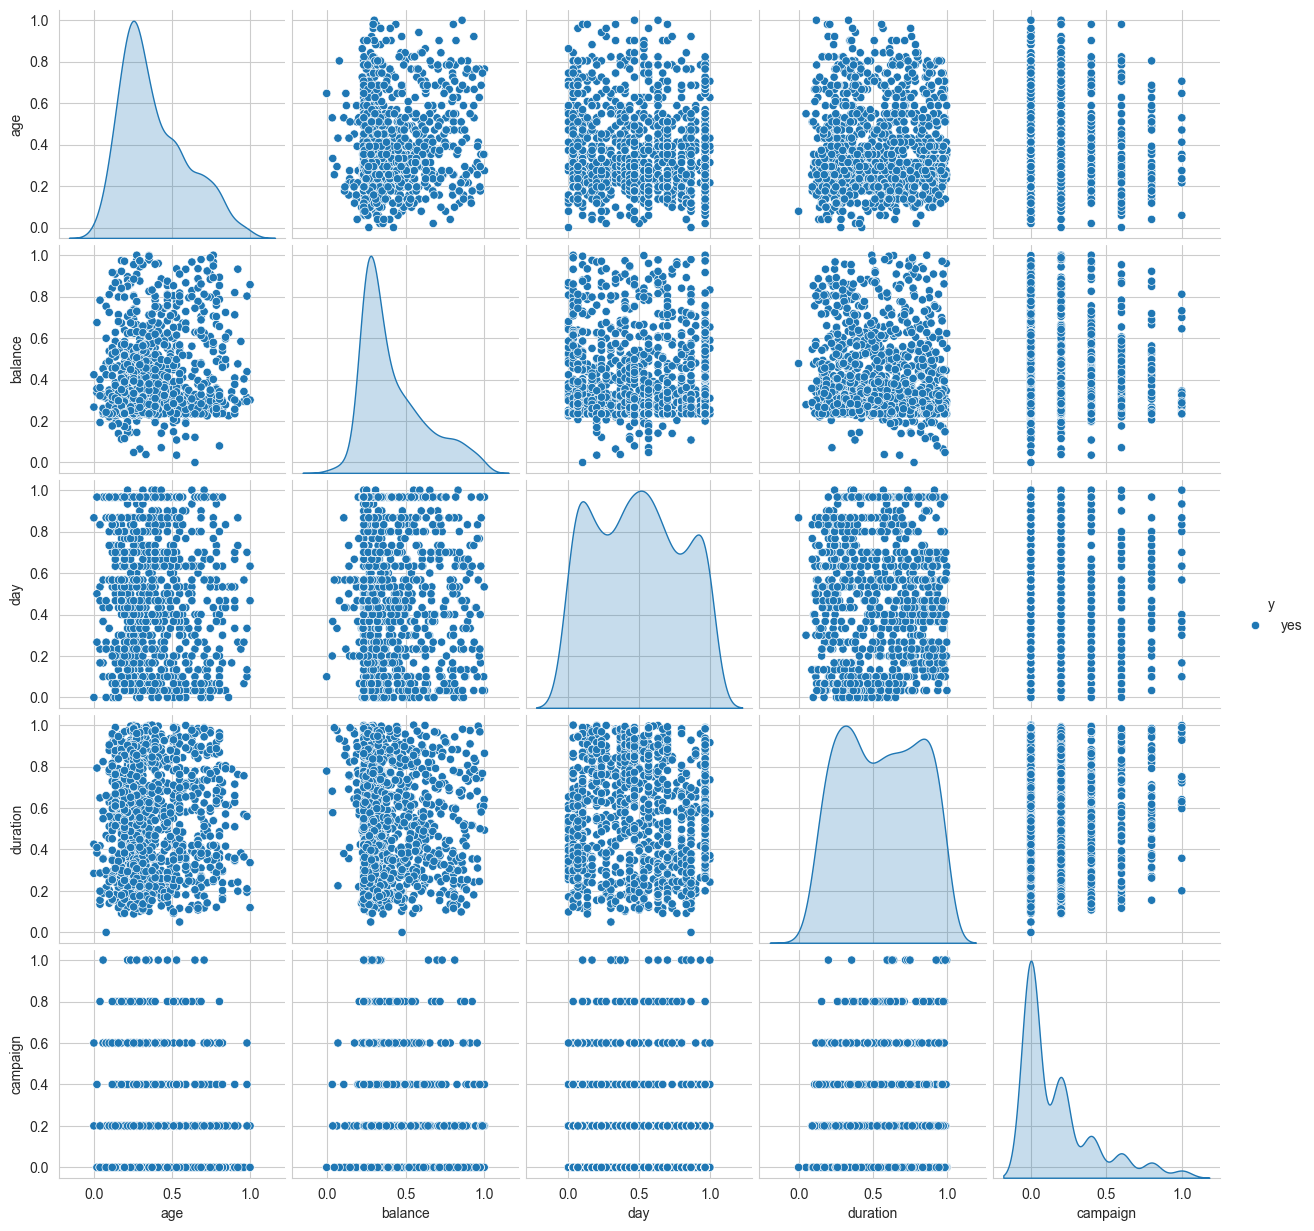

In [116]:
from sklearn.preprocessing import MinMaxScaler
# Create a copy of the dataset to avoid altering the original data
data_scaled = subscribed_filtered_data.copy()

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Apply MinMaxScaler to continuous features (scaling them between 0 and 1)
data_scaled[numeric_features] = scaler.fit_transform(data_scaled[numeric_features])

# Plot the pairplot of the scaled numerical features with hue='y'
sns.set_style('whitegrid')
sns.pairplot(data_scaled[numeric_features + ['y']], hue='y', diag_kind='kde')
plt.show()

Now we're ready to feed the twice-filtered data into models and begin the <b> 2nd layer <b>.

<b> Data transformation of the categorical variables <b>

<h3>Label Encoding:</h3>
marital: There are only three categories that are naturally ordinal (single, married, divorced). This can be label-encoded.
<br>
contact: There are only two categories (cellular, telephone), so label encoding is sufficient.
<h3>One-hot Encoding:</h3>
job: Multiple non-ordinal categories (e.g., management, blue-collar, services) that don’t have a natural order, so one-hot encoding is more appropriate.
<br>
education: Although "primary," "secondary," and "tertiary" imply some order, the "unknown" category doesn't fit that pattern well, so it would be better to one-hot encode it.
<br>
month: While months have a temporal order, the relationship between the months in this dataset is likely categorical, so one-hot encoding is better.

In [152]:
data_cleaned_filtered.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
12657,27,management,single,secondary,no,35,no,no,cellular,4,jul,255,1,0
12658,54,blue-collar,married,primary,no,466,no,no,cellular,4,jul,297,1,0
12660,31,technician,single,secondary,no,19,no,no,telephone,4,jul,65,2,0
12661,27,technician,single,secondary,no,126,yes,yes,cellular,4,jul,436,4,0
12663,50,blue-collar,married,secondary,no,1329,yes,yes,telephone,4,jul,141,2,0


In [30]:
data_cleaned_filtered.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
12657,27,management,single,secondary,no,35,no,no,cellular,4,jul,255,1,0
12658,54,blue-collar,married,primary,no,466,no,no,cellular,4,jul,297,1,0
12660,31,technician,single,secondary,no,19,no,no,telephone,4,jul,65,2,0
12661,27,technician,single,secondary,no,126,yes,yes,cellular,4,jul,436,4,0
12663,50,blue-collar,married,secondary,no,1329,yes,yes,telephone,4,jul,141,2,0


In [22]:


# Initialize LabelEncoder
label_encoder = LabelEncoder()

data_cleaned_filtered_transformed=data_cleaned_filtered.copy()

# Columns to label encode
label_encode_cols = ['marital', 'contact']

# Apply label encoding to marital and contact
for col in label_encode_cols:
    data_cleaned_filtered_transformed[col] = label_encoder.fit_transform(data_cleaned_filtered_transformed[col])

# Columns to one-hot encode
one_hot_encode_cols = ['job', 'education', 'month']

# Apply one-hot encoding to job, education, and month
data_cleaned_filtered_transformed = pd.get_dummies(data_cleaned_filtered_transformed, columns=one_hot_encode_cols, drop_first=True)

# Identify the one-hot encoded columns (boolean columns)
one_hot_cols = data_cleaned_filtered_transformed.filter(like='_').columns

# Convert True/False to 1/0 for the one-hot encoded columns
data_cleaned_filtered_transformed[one_hot_cols] = data_cleaned_filtered_transformed[one_hot_cols].astype(int)

# Check the transformed dataset
data_cleaned_filtered_transformed.head()


,age,marital,default,balance,housing,loan,contact,day,duration,campaign,...,education_unknown,month_aug,month_dec,month_feb,month_jul,month_jun,month_mar,month_may,month_nov,month_oct
12657,27,2,no,35,no,no,0,4,255,1,...,0,0,0,0,1,0,0,0,0,0
12658,54,1,no,466,no,no,0,4,297,1,...,0,0,0,0,1,0,0,0,0,0
12660,31,2,no,19,no,no,1,4,65,2,...,0,0,0,0,1,0,0,0,0,0
12661,27,2,no,126,yes,yes,0,4,436,4,...,0,0,0,0,1,0,0,0,0,0
12663,50,1,no,1329,yes,yes,1,4,141,2,...,0,0,0,0,1,0,0,0,0,0


In [23]:
# Convert 'yes' to 1 and 'no' to 0 in binary features
for col in binary_features:
    data_cleaned_filtered_transformed[col] = data_cleaned_filtered_transformed[col].map({'yes': 1, 'no': 0})

# Check the transformed dataset
data_cleaned_filtered_transformed.head()

,age,marital,default,balance,housing,loan,contact,day,duration,campaign,...,education_unknown,month_aug,month_dec,month_feb,month_jul,month_jun,month_mar,month_may,month_nov,month_oct
12657,27,2,0,35,0,0,0,4,255,1,...,0,0,0,0,1,0,0,0,0,0
12658,54,1,0,466,0,0,0,4,297,1,...,0,0,0,0,1,0,0,0,0,0
12660,31,2,0,19,0,0,1,4,65,2,...,0,0,0,0,1,0,0,0,0,0
12661,27,2,0,126,1,1,0,4,436,4,...,0,0,0,0,1,0,0,0,0,0
12663,50,1,0,1329,1,1,1,4,141,2,...,0,0,0,0,1,0,0,0,0,0


<b> Modelling with Imbalanced Data <b>

In [24]:
from sklearn.model_selection import train_test_split


# Convert 'y' to integer type
data_cleaned_filtered_transformed['y'] = data_cleaned_filtered_transformed['y'].astype(int)
y= data_cleaned_filtered_transformed['y']
X = data_cleaned_filtered_transformed.drop(['y'],axis=1)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Gathering feature importance on original imbalanced dataset

                Feature  Importance
8              duration        0.38
7                   day        0.12
29            month_mar        0.10
28            month_jun        0.08
0                   age        0.08
27            month_jul        0.05
24            month_aug        0.04
3               balance        0.03
32            month_oct        0.02
26            month_feb        0.02
9              campaign        0.02
4               housing        0.02
30            month_may        0.01
22   education_tertiary        0.01
31            month_nov        0.00
2               default        0.00
1               marital        0.00
17          job_student        0.00
11     job_entrepreneur        0.00
13       job_management        0.00
5                  loan        0.00
12        job_housemaid        0.00
20          job_unknown        0.00
21  education_secondary        0.00
6               contact        0.00
10      job_blue-collar        0.00
25            month_dec     

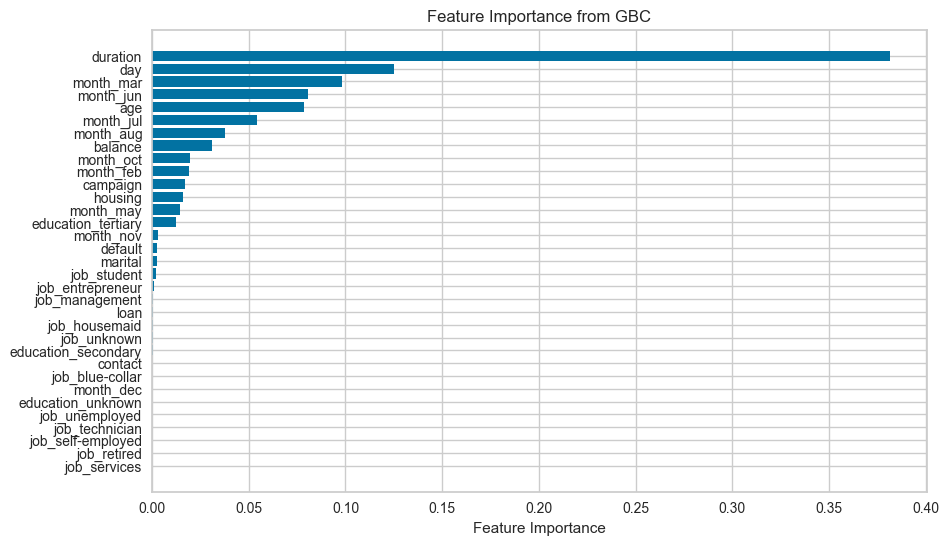

In [142]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize and fit the GBC model
gbc_model = GradientBoostingClassifier()
gbc_model.fit(X_train, y_train)

# Get feature importance
feature_importances = gbc_model.feature_importances_

# Create a DataFrame for better visualization
features = X_train.columns  # Make sure X_train is a DataFrame, else adjust accordingly
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Print the DataFrame
print(importance_df)

# Optionally, plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance from GBC')
plt.gca().invert_yaxis()
plt.show()


In [48]:
from lazypredict.Supervised import LazyClassifier

In [181]:

# Initialize and fit LazyClassifier
clf = LazyClassifier()
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

# View the performance comparison
print(models)


 97%|█████████▋| 30/31 [15:17<00:02,  2.51s/it] 

[LightGBM] [Info] Number of positive: 715, number of negative: 12945
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 684
[LightGBM] [Info] Number of data points in the train set: 13660, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.052343 -> initscore=-2.896182
[LightGBM] [Info] Start training from score -2.896182


100%|██████████| 31/31 [15:18<00:00, 29.63s/it]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
NearestCentroid                    0.86               0.79     0.79      0.89   
XGBClassifier                      0.95               0.68     0.68      0.95   
DecisionTreeClassifier             0.93               0.66     0.66      0.93   
PassiveAggressiveClassifier        0.92               0.66     0.66      0.92   
GaussianNB                         0.43               0.66     0.66      0.55   
LGBMClassifier                     0.95               0.65     0.65      0.95   
Perceptron                         0.88               0.64     0.64      0.90   
ExtraTreeClassifier                0.93               0.64     0.64      0.93   
LinearDiscriminantAnalysis         0.94               0.64     0.64      0.94   
BaggingClassifier                  0.95               0.62     0.62      0.94   
AdaBoostClassifier          

In [16]:
from pycaret.classification import *

# Load dataset and initialize PyCaret
clf = setup(data=data_cleaned_filtered_transformed, target='y')

# Compare models and select the best
best_model = compare_models()

# Tune the best model
tuned_model = tune_model(best_model)


,Description,Value
0,Session id,7981
1,Target,y
2,Target type,Binary
3,Target mapping,"no: 0, yes: 1"
4,Original data shape,"(19515, 34)"
5,Transformed data shape,"(19515, 34)"
6,Transformed train set shape,"(13660, 34)"
7,Transformed test set shape,"(5855, 34)"
8,Numeric features,33
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9534,0.9147,0.9534,0.9440,0.9405,0.2811,0.3490,1.3680
lightgbm,Light Gradient Boosting Machine,0.9529,0.9331,0.9529,0.9434,0.9449,0.3683,0.3968,0.4050
gbc,Gradient Boosting Classifier,0.9526,0.9242,0.9526,0.9421,0.9425,0.3243,0.3664,1.7290
lr,Logistic Regression,0.9510,0.9047,0.9510,0.9385,0.9388,0.2697,0.3190,5.8240
et,Extra Trees Classifier,0.9507,0.9070,0.9507,0.9380,0.9380,0.2578,0.3099,1.2370
ridge,Ridge Classifier,0.9488,0.9054,0.9488,0.9363,0.9273,0.0788,0.1621,0.1250
ada,Ada Boost Classifier,0.9484,0.9034,0.9484,0.9350,0.9385,0.2860,0.3129,0.7360
dummy,Dummy Classifier,0.9478,0.5000,0.9478,0.8983,0.9224,0.0000,0.0000,0.1000
lda,Linear Discriminant Analysis,0.9454,0.9054,0.9454,0.9351,0.9389,0.3204,0.3317,0.2020
knn,K Neighbors Classifier,0.9437,0.6357,0.9437,0.9129,0.9241,0.0596,0.0842,0.5790


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9480,0.5000,0.9480,0.8987,0.9227,0.0000,0.0000
1,0.9480,0.5000,0.9480,0.8987,0.9227,0.0000,0.0000
2,0.9480,0.5000,0.9480,0.8987,0.9227,0.0000,0.0000
3,0.9480,0.5000,0.9480,0.8987,0.9227,0.0000,0.0000
4,0.9480,0.5000,0.9480,0.8987,0.9227,0.0000,0.0000
5,0.9480,0.5000,0.9480,0.8987,0.9227,0.0000,0.0000
6,0.9480,0.5000,0.9480,0.8987,0.9227,0.0000,0.0000
7,0.9473,0.5000,0.9473,0.8974,0.9217,0.0000,0.0000
8,0.9473,0.5000,0.9473,0.8974,0.9217,0.0000,0.0000


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [17]:
best_model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=-1,
                       oob_score=False, random_state=7981, verbose=0,
                       warm_start=False)

<b> Next Steps/Path Forward <b>

As per Lazy-Predict and PyCaret the best models (on the imbalanced dataset) are NearestCentroid, XGBoost, Random Forest and LGBM. Before addressing the imbalance in the dataset lets evaluate the metrics of these best performing models. 
We know what we're looking for...a model that correctly identfies most of the the subscribers (high recall for class 1) while making the fewest misclassifications of subscribers (high precision for class 1). High True Positives and low False Positives. 

<br>

After this, SMOTE-Tomek will be used for balancing the data and the models will be re-evaluated. And then SMOTE-ENN and models re-evaluated. In this section our objective is to find the model that has the best performance as per the above stated critieria. 

In [27]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
target_names = ['Non-Subscribers', 'Subscribers']

                 precision    recall  f1-score   support

Non-Subscribers       0.96      0.71      0.82      5552
    Subscribers       0.08      0.43      0.13       303

       accuracy                           0.70      5855
      macro avg       0.52      0.57      0.47      5855
   weighted avg       0.91      0.70      0.78      5855



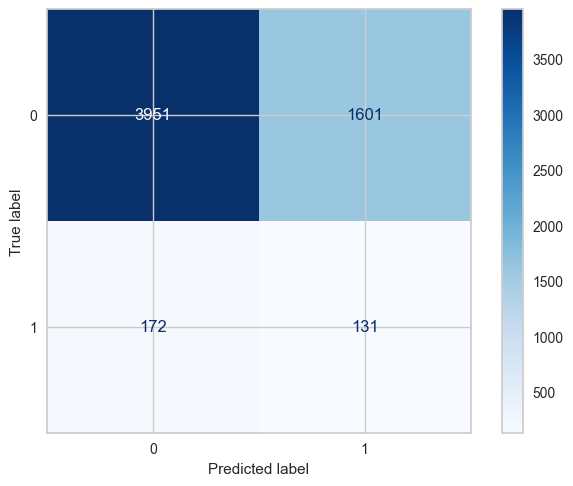

In [36]:
from sklearn.neighbors import NearestCentroid

# Initialize NearestCentroid classifier
nc_model = NearestCentroid()

# Train the model
nc_model.fit(X_train, y_train)

# Predict on the test set
y_pred = nc_model.predict(X_test)
#Evaluate the model
print(classification_report(y_test, y_pred, target_names=target_names))
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()


                 precision    recall  f1-score   support

Non-Subscribers       0.95      1.00      0.97      5552
    Subscribers       0.62      0.14      0.22       303

       accuracy                           0.95      5855
      macro avg       0.79      0.57      0.60      5855
   weighted avg       0.94      0.95      0.94      5855



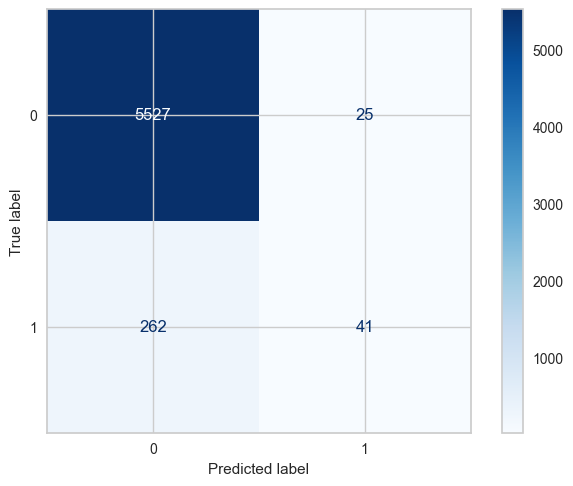

In [37]:
from sklearn.ensemble import RandomForestClassifier
# Initialize the RandomForestClassifier
rf_model = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=-1,
                       oob_score=False, random_state=7981, verbose=0,
                       warm_start=False)
# Train the model
rf_model.fit(X_train, y_train)
# Predict on the test set
y_pred = rf_model.predict(X_test)
#Evaluate the model
print(classification_report(y_test, y_pred, target_names=target_names))
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()


                 precision    recall  f1-score   support

Non-Subscribers       0.97      0.98      0.98      5552
    Subscribers       0.56      0.37      0.45       303

       accuracy                           0.95      5855
      macro avg       0.76      0.68      0.71      5855
   weighted avg       0.95      0.95      0.95      5855



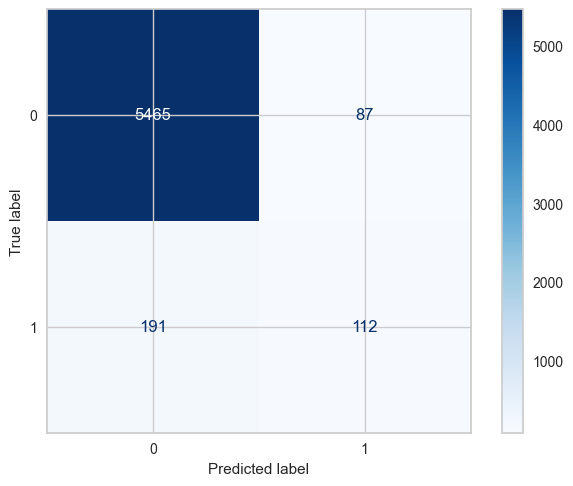

In [40]:
import xgboost as xgb
from xgboost import XGBClassifier
# Initialize the XGBoost classifier
xgb_model = XGBClassifier()
#train the model 
xgb_model.fit(X_train, y_train)
# Predict on the test set
y_pred = xgb_model.predict(X_test)
#Evaluate the model
print(classification_report(y_test, y_pred, target_names=target_names))
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()

[LightGBM] [Info] Number of positive: 715, number of negative: 12945
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001940 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 657
[LightGBM] [Info] Number of data points in the train set: 13660, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.052343 -> initscore=-2.896182
[LightGBM] [Info] Start training from score -2.896182
                 precision    recall  f1-score   support

Non-Subscribers       0.96      0.99      0.98      5552
    Subscribers       0.60      0.28      0.38       303

       accuracy                           0.95      5855
      macro avg       0.78      0.64      0.68      5855
   weighted avg       0.94      0.95      0.95      5855



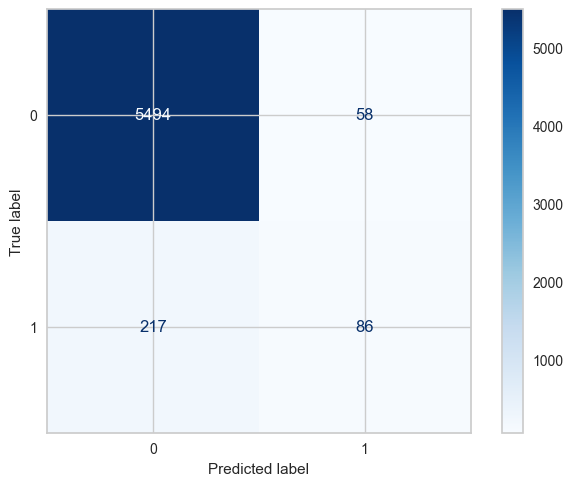

In [41]:
import lightgbm as lgb

# Initialize LGBMClassifier
lgbm_model = lgb.LGBMClassifier(
    boosting_type='gbdt',  # Gradient Boosting Decision Tree
    num_leaves=31,         # Number of leaves in one tree
    max_depth=-1,          # Maximum tree depth for base learners
    learning_rate=0.1,     # Learning rate
    n_estimators=100,      # Number of boosted trees to fit
    random_state=42
)

# Fit the model with data
# Train the model
lgbm_model.fit(X_train, y_train)

# Predict on the test set
y_pred = lgbm_model.predict(X_test)

#Evaluate the model
print(classification_report(y_test, y_pred, target_names=target_names))
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()

Observation: All 4 models show high degree of misclassification. In all models less than half of the subscribers were identified. In the first model, Nearest Centroid, that identified the most subscribers (43%) the precision was only 8% meaning 92% of its predictions were wrong. 

<b>Modelling using SMOTE-Tomek Balanced Data</b>

In [71]:
# Import necessary libraries
from imblearn.combine import SMOTETomek

# Apply SMOTE-Tomek
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)

# Check the distribution after resampling
from collections import Counter
print(f'Original dataset class distribution: {Counter(y_train)}')
print(f'Resampled dataset class distribution: {Counter(y_resampled)}')

Original dataset class distribution: Counter({0: 12945, 1: 715})
Resampled dataset class distribution: Counter({0: 12691, 1: 12691})


In [64]:

# Convert X_resampled to a DataFrame (if it's not already)
X_resampled_df = pd.DataFrame(X_resampled, columns=X_train.columns)

# Convert y_resampled to a DataFrame (if it's not already)
y_resampled_df = pd.DataFrame(y_resampled, columns=['y'])  # Assuming 'y' is the target variable name

# Concatenate X_resampled and y_resampled into a single DataFrame
data_resampled_smote_tomek = pd.concat([X_resampled_df, y_resampled_df], axis=1)

# Load dataset and initialize PyCaret
clf = setup(data=data_resampled_smote_tomek, target='y')

# Compare models and select the best
best_model = compare_models()

# Tune the best model
tuned_model = tune_model(best_model)


Original dataset class distribution: Counter({0: 12945, 1: 715})
Resampled dataset class distribution: Counter({0: 12691, 1: 12691})


,Description,Value
0,Session id,2242
1,Target,y
2,Target type,Binary
3,Original data shape,"(25382, 34)"
4,Transformed data shape,"(25382, 34)"
5,Transformed train set shape,"(17767, 34)"
6,Transformed test set shape,"(7615, 34)"
7,Numeric features,33
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9696,0.9956,0.9633,0.9756,0.9694,0.9392,0.9393,1.4920
lightgbm,Light Gradient Boosting Machine,0.9658,0.9947,0.9666,0.9652,0.9659,0.9317,0.9317,0.4070
et,Extra Trees Classifier,0.9653,0.9945,0.9581,0.9721,0.9651,0.9307,0.9308,1.4530
dt,Decision Tree Classifier,0.9470,0.9470,0.9559,0.9393,0.9475,0.8941,0.8942,0.2000
gbc,Gradient Boosting Classifier,0.9470,0.9882,0.9504,0.9440,0.9472,0.8940,0.8940,1.7820
lr,Logistic Regression,0.9435,0.9845,0.9439,0.9432,0.9436,0.8871,0.8871,2.1720
ridge,Ridge Classifier,0.9410,0.9824,0.9361,0.9454,0.9407,0.8820,0.8821,0.0930
ada,Ada Boost Classifier,0.9410,0.9851,0.9425,0.9398,0.9411,0.8820,0.8821,0.7040
lda,Linear Discriminant Analysis,0.9410,0.9823,0.9361,0.9453,0.9407,0.8819,0.8820,0.1790
nb,Naive Bayes,0.8720,0.9472,0.9272,0.8352,0.8787,0.7440,0.7487,0.0930


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9308,0.9845,0.9235,0.9372,0.9303,0.8616,0.8617
1,0.9460,0.9893,0.9269,0.9637,0.9450,0.8920,0.8926
2,0.9370,0.9847,0.9224,0.9502,0.9361,0.8739,0.8743
3,0.9454,0.9880,0.9415,0.9490,0.9452,0.8908,0.8909
4,0.9449,0.9873,0.9426,0.9468,0.9447,0.8897,0.8897
5,0.9403,0.9862,0.9336,0.9463,0.9399,0.8807,0.8808
6,0.9330,0.9848,0.9212,0.9435,0.9322,0.8661,0.8663
7,0.9307,0.9842,0.9257,0.9352,0.9304,0.8615,0.8615
8,0.9369,0.9839,0.9234,0.9491,0.9361,0.8739,0.8742


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [ ]:
# Assuming X_train, y_train are already defined

# Initialize and fit the GBC model
gbc_model = GradientBoostingClassifier()
gbc_model.fit(X_resampled_df, y_train)

# Get feature importance
feature_importances = gbc_model.feature_importances_

# Create a DataFrame for better visualization
features = X_train.columns  # Make sure X_train is a DataFrame, else adjust accordingly
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Print the DataFrame
print(importance_df)

# Optionally, plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance from GBC')
plt.gca().invert_yaxis()
plt.show()


In [54]:
# Initialize and fit LazyClassifier
clf = LazyClassifier()
models, predictions = clf.fit(X_resampled, X_test, y_resampled, y_test)

# View the performance comparison
print(models)

 97%|█████████▋| 28/29 [02:47<00:04,  4.51s/it]

[LightGBM] [Info] Number of positive: 12691, number of negative: 12691
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005857 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 684
[LightGBM] [Info] Number of data points in the train set: 25382, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


100%|██████████| 29/29 [02:48<00:00,  5.80s/it]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
LGBMClassifier                     0.94               0.72     0.72      0.94   
LogisticRegression                 0.92               0.70     0.70      0.93   
XGBClassifier                      0.94               0.70     0.70      0.94   
NearestCentroid                    0.90               0.70     0.70      0.91   
LinearSVC                          0.92               0.70     0.70      0.93   
AdaBoostClassifier                 0.91               0.69     0.69      0.92   
DecisionTreeClassifier             0.91               0.69     0.69      0.92   
BaggingClassifier                  0.94               0.68     0.68      0.94   
RidgeClassifierCV                  0.92               0.68     0.68      0.93   
LinearDiscriminantAnalysis         0.92               0.68     0.68      0.93   
RidgeClassifier             

it looks like the performance of the models reduced after SMOTE Tomek...

[LightGBM] [Info] Number of positive: 12691, number of negative: 12691
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001689 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 657
[LightGBM] [Info] Number of data points in the train set: 25382, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
                 precision    recall  f1-score   support

Non-Subscribers       0.97      0.96      0.97      5552
    Subscribers       0.40      0.45      0.42       303

       accuracy                           0.94      5855
      macro avg       0.68      0.71      0.69      5855
   weighted avg       0.94      0.94      0.94      5855



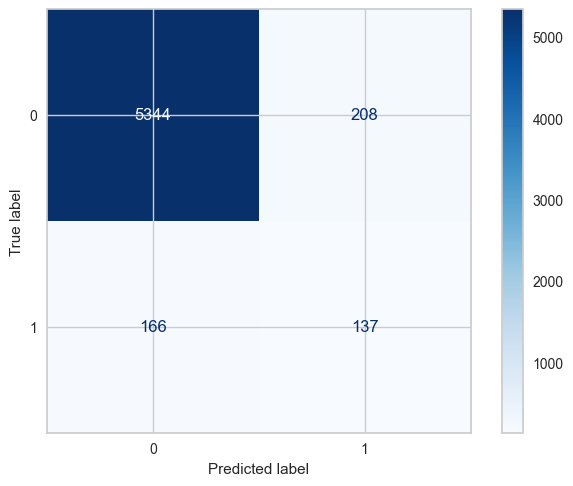

In [56]:
# Initialize LGBMClassifier
lgbm_model = lgb.LGBMClassifier(
    boosting_type='gbdt',  # Gradient Boosting Decision Tree
    num_leaves=31,         # Number of leaves in one tree
    max_depth=-1,          # Maximum tree depth for base learners
    learning_rate=0.1,     # Learning rate
    n_estimators=100,      # Number of boosted trees to fit
    random_state=42
)

# Fit the model with data
# Train the model
lgbm_model.fit(X_resampled, y_resampled)

# Predict on the test set
y_pred = lgbm_model.predict(X_test)

#Evaluate the model
print(classification_report(y_test, y_pred, target_names=target_names))
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()

                 precision    recall  f1-score   support

Non-Subscribers       0.97      0.96      0.97      5552
    Subscribers       0.39      0.43      0.41       303

       accuracy                           0.94      5855
      macro avg       0.68      0.70      0.69      5855
   weighted avg       0.94      0.94      0.94      5855



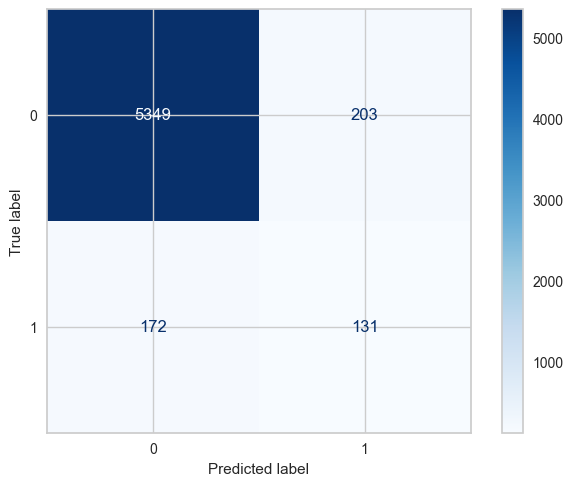

In [72]:
# Initialize the XGBoost classifier
xgb_model = XGBClassifier()
#train the model 
xgb_model.fit(X_resampled,y_resampled)
# Predict on the test set
y_pred = xgb_model.predict(X_test)
#Evaluate the model
print(classification_report(y_test, y_pred, target_names=target_names))
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()

                 precision    recall  f1-score   support

Non-Subscribers       0.97      0.95      0.96      5552
    Subscribers       0.31      0.46      0.37       303

       accuracy                           0.92      5855
      macro avg       0.64      0.70      0.66      5855
   weighted avg       0.94      0.92      0.93      5855



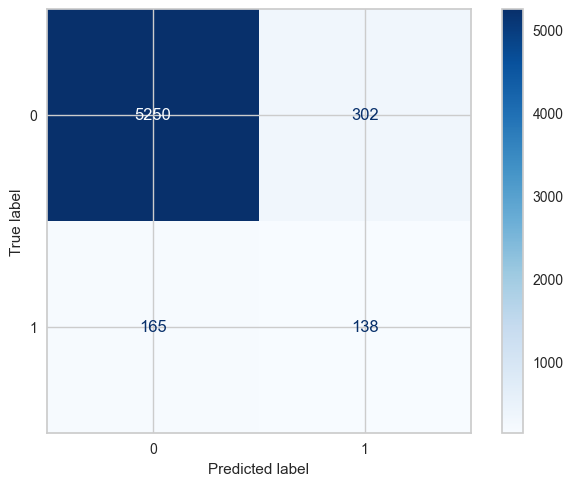

In [73]:
# train a logistic regression model on the training set
from sklearn.linear_model import LogisticRegression

# instantiate the model
logreg = LogisticRegression(solver='liblinear', random_state=0)

# fit the model
logreg.fit(X_resampled, y_resampled)

# Predict on the test set
y_pred = logreg.predict(X_test)
#Evaluate the model
print(classification_report(y_test, y_pred, target_names=target_names))
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()

                 precision    recall  f1-score   support

Non-Subscribers       0.96      0.98      0.97      5552
    Subscribers       0.44      0.34      0.38       303

       accuracy                           0.94      5855
      macro avg       0.70      0.66      0.68      5855
   weighted avg       0.94      0.94      0.94      5855



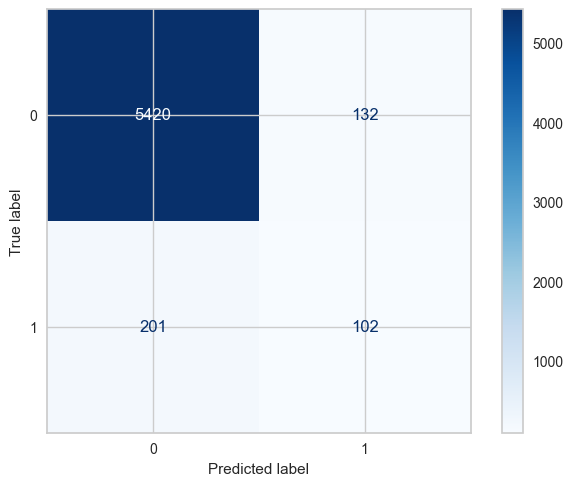

In [57]:
# Initialize the RandomForestClassifier
rf_model = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=-1,
                       oob_score=False, random_state=7981, verbose=0,
                       warm_start=False)
# Train the model
rf_model.fit(X_resampled, y_resampled)
# Predict on the test set
y_pred = rf_model.predict(X_test)
#Evaluate the model
print(classification_report(y_test, y_pred, target_names=target_names))
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()

The recall has increased. now more subscribers are being identified but the precision has reduced. 

                 precision    recall  f1-score   support

Non-Subscribers       0.97      0.61      0.75      5552
    Subscribers       0.08      0.60      0.14       303

       accuracy                           0.61      5855
      macro avg       0.52      0.60      0.44      5855
   weighted avg       0.92      0.61      0.72      5855



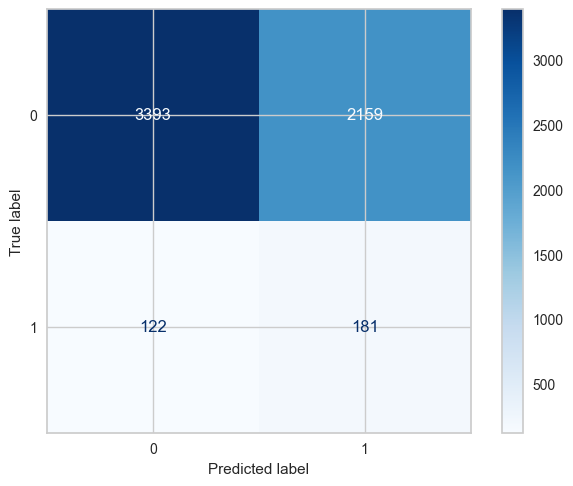

In [65]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# Initialize the QDA classifier
qda = QuadraticDiscriminantAnalysis()

# Fit the QDA classifier on the training data
qda.fit(X_resampled, y_resampled)

# Make predictions on the test data
y_pred = qda.predict(X_test)

#Evaluate the model
print(classification_report(y_test, y_pred, target_names=target_names))
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()


<b> Modeling with data balanced using SMOTE-ENN </b>

Next Step: Try Smote-enn and then re-evaluate model

In [25]:
from imblearn.combine import SMOTEENN

# Apply SMOTE-ENN to the training set only
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)

# Check the distribution after resampling
print(f'Original dataset class distribution: {Counter(y_train)}')
print(f'Resampled dataset class distribution: {Counter(y_resampled)}')


NameError: name 'Counter' is not defined

In [59]:
# Initialize and fit LazyClassifier
clf = LazyClassifier()
models, predictions = clf.fit(X_resampled, X_test, y_resampled, y_test)

# View the performance comparison
print(models)

 97%|█████████▋| 28/29 [08:05<00:03,  3.66s/it]

[LightGBM] [Info] Number of positive: 11380, number of negative: 9229
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004890 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 684
[LightGBM] [Info] Number of data points in the train set: 20609, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552186 -> initscore=0.209507
[LightGBM] [Info] Start training from score 0.209507


100%|██████████| 29/29 [08:06<00:00, 16.76s/it]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
XGBClassifier                      0.91               0.78     0.78      0.92   
LGBMClassifier                     0.91               0.78     0.78      0.92   
PassiveAggressiveClassifier        0.86               0.76     0.76      0.89   
AdaBoostClassifier                 0.88               0.75     0.75      0.91   
LogisticRegression                 0.90               0.75     0.75      0.91   
LinearSVC                          0.90               0.74     0.74      0.91   
BaggingClassifier                  0.91               0.73     0.73      0.92   
CalibratedClassifierCV             0.91               0.73     0.73      0.92   
Perceptron                         0.87               0.73     0.73      0.89   
DecisionTreeClassifier             0.89               0.73     0.73      0.91   
RandomForestClassifier      

                 precision    recall  f1-score   support

Non-Subscribers       0.98      0.93      0.95      5552
    Subscribers       0.32      0.64      0.43       303

       accuracy                           0.91      5855
      macro avg       0.65      0.78      0.69      5855
   weighted avg       0.94      0.91      0.92      5855



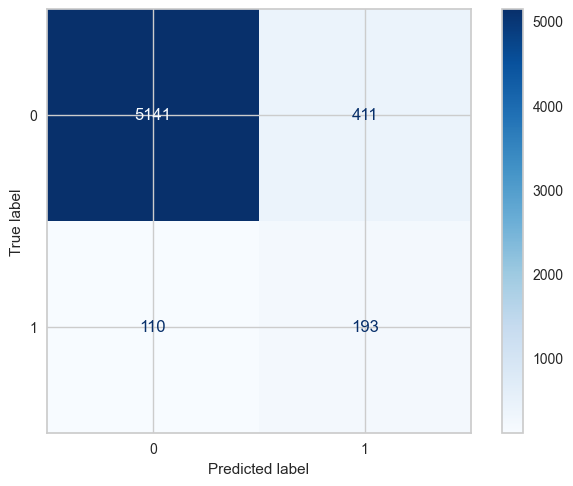

In [75]:
# Initialize the XGBoost classifier
xgb_model = XGBClassifier()
#train the model 
xgb_model.fit(X_resampled, y_resampled)
# Predict on the test set
y_pred = xgb_model.predict(X_test)
#Evaluate the model
print(classification_report(y_test, y_pred, target_names=target_names))
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()

[LightGBM] [Info] Number of positive: 11380, number of negative: 9229
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005776 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 657
[LightGBM] [Info] Number of data points in the train set: 20609, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552186 -> initscore=0.209507
[LightGBM] [Info] Start training from score 0.209507
                 precision    recall  f1-score   support

Non-Subscribers       0.98      0.92      0.95      5552
    Subscribers       0.30      0.63      0.41       303

       accuracy                           0.91      5855
      macro avg       0.64      0.78      0.68      5855
   weighted avg       0.94      0.91      0.92      5855



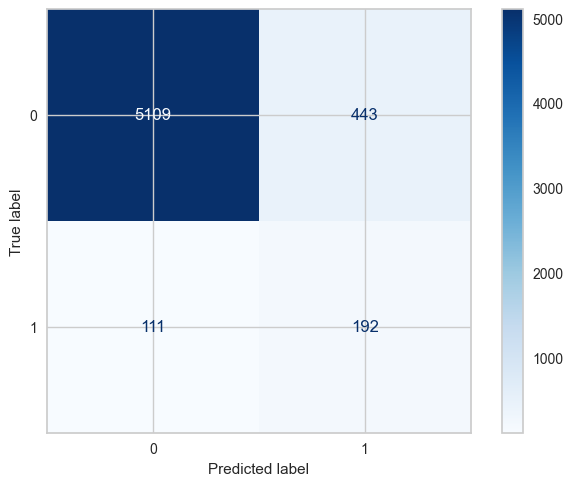

In [61]:
# Initialize LGBMClassifier
lgbm_model = lgb.LGBMClassifier(
    boosting_type='gbdt',  # Gradient Boosting Decision Tree
    num_leaves=31,         # Number of leaves in one tree
    max_depth=-1,          # Maximum tree depth for base learners
    learning_rate=0.1,     # Learning rate
    n_estimators=100,      # Number of boosted trees to fit
    random_state=42
)

# Fit the model with data
# Train the model
lgbm_model.fit(X_resampled, y_resampled)

# Predict on the test set
y_pred = lgbm_model.predict(X_test)

#Evaluate the model
print(classification_report(y_test, y_pred, target_names=target_names))
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()

In [145]:
# Convert X_resampled to a DataFrame (if it's not already)
X_resampled_df = pd.DataFrame(X_resampled, columns=X_train.columns)

# Convert y_resampled to a DataFrame (if it's not already)
y_resampled_df = pd.DataFrame(y_resampled, columns=['y'])  # Assuming 'y' is the target variable name

# Concatenate X_resampled and y_resampled into a single DataFrame
data_resampled_smote_enn = pd.concat([X_resampled_df, y_resampled_df], axis=1)


In [67]:

# Load dataset and initialize PyCaret
clf = setup(data=data_resampled_smote_enn, target='y')

# Compare models and select the best
best_model = compare_models()

# Tune the best model
tuned_model = tune_model(best_model)

,Description,Value
0,Session id,4317
1,Target,y
2,Target type,Binary
3,Original data shape,"(20609, 34)"
4,Transformed data shape,"(20609, 34)"
5,Transformed train set shape,"(14426, 34)"
6,Transformed test set shape,"(6183, 34)"
7,Numeric features,33
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9732,0.9966,0.9745,0.9770,0.9757,0.9459,0.9459,1.3050
lightgbm,Light Gradient Boosting Machine,0.9722,0.9963,0.9793,0.9707,0.9749,0.9437,0.9438,0.4160
et,Extra Trees Classifier,0.9686,0.9957,0.9662,0.9767,0.9714,0.9366,0.9367,1.1980
knn,K Neighbors Classifier,0.9587,0.9917,0.9933,0.9358,0.9637,0.9159,0.9181,0.5970
lr,Logistic Regression,0.9550,0.9892,0.9605,0.9582,0.9593,0.9090,0.9091,4.2770
dt,Decision Tree Classifier,0.9545,0.9531,0.9665,0.9519,0.9591,0.9079,0.9081,0.2350
ada,Ada Boost Classifier,0.9545,0.9894,0.9597,0.9579,0.9588,0.9079,0.9079,0.6500
gbc,Gradient Boosting Classifier,0.9545,0.9912,0.9648,0.9534,0.9591,0.9079,0.9081,1.5490
ridge,Ridge Classifier,0.9498,0.9873,0.9473,0.9613,0.9542,0.8987,0.8988,0.1030
lda,Linear Discriminant Analysis,0.9497,0.9873,0.9470,0.9614,0.9541,0.8986,0.8987,0.2030


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9466,0.9860,0.9498,0.9534,0.9516,0.8921,0.8922
1,0.9453,0.9905,0.9486,0.9521,0.9503,0.8893,0.8894
2,0.9501,0.9906,0.9548,0.9548,0.9548,0.8991,0.8991
3,0.9480,0.9860,0.9498,0.9558,0.9528,0.8950,0.8950
4,0.9362,0.9863,0.9511,0.9346,0.9428,0.8708,0.8710
5,0.9369,0.9865,0.9385,0.9468,0.9427,0.8726,0.8727
6,0.9300,0.9830,0.9397,0.9338,0.9368,0.8583,0.8583
7,0.9327,0.9844,0.9296,0.9475,0.9385,0.8643,0.8645
8,0.9424,0.9868,0.9397,0.9553,0.9474,0.8838,0.8840


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [68]:
best_model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=-1,
                       oob_score=False, random_state=4317, verbose=0,
                       warm_start=False)

                 precision    recall  f1-score   support

Non-Subscribers       0.97      0.94      0.96      5552
    Subscribers       0.33      0.50      0.40       303

       accuracy                           0.92      5855
      macro avg       0.65      0.72      0.68      5855
   weighted avg       0.94      0.92      0.93      5855



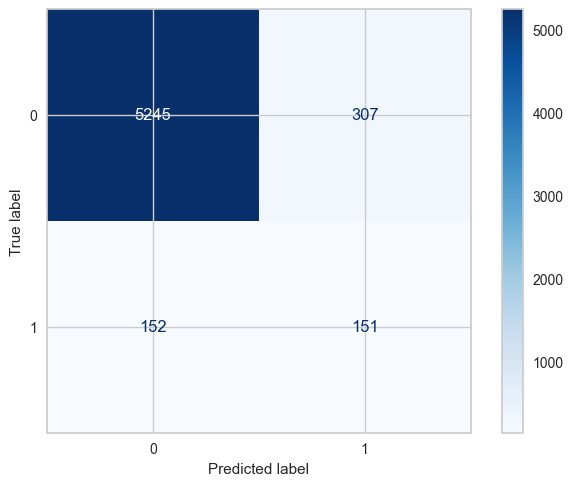

In [69]:
# Initialize the RandomForestClassifier
rf_model = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=-1,
                       oob_score=False, random_state=4317, verbose=0,
                       warm_start=False)
# Train the model
rf_model.fit(X_resampled, y_resampled)
# Predict on the test set
y_pred = rf_model.predict(X_test)
#Evaluate the model
print(classification_report(y_test, y_pred, target_names=target_names))
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()

                 precision    recall  f1-score   support

Non-Subscribers       0.98      0.90      0.94      5552
    Subscribers       0.27      0.71      0.39       303

       accuracy                           0.89      5855
      macro avg       0.63      0.80      0.66      5855
   weighted avg       0.95      0.89      0.91      5855



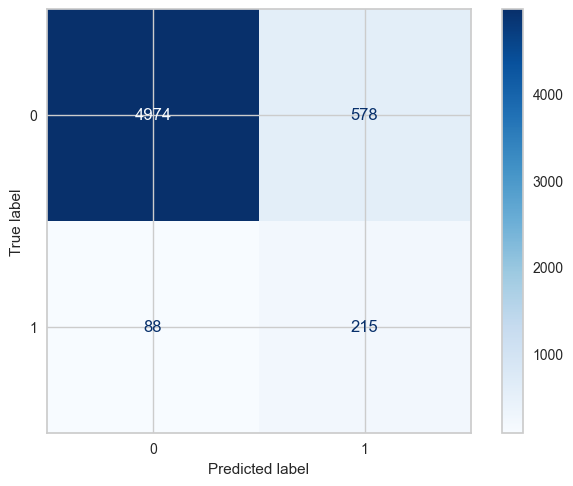

In [144]:
# Initialize the Gradient Boosting classifier
gbc_model = GradientBoostingClassifier()

# Train the model
gbc_model.fit(X_resampled, y_resampled)

# Predict on the test set
y_pred = gbc_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred, target_names=target_names))
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()


                Feature  Importance
8              duration        0.43
4               housing        0.12
24            month_aug        0.11
27            month_jul        0.10
31            month_nov        0.04
30            month_may        0.03
10      job_blue-collar        0.03
9              campaign        0.02
26            month_feb        0.02
5                  loan        0.02
21  education_secondary        0.02
7                   day        0.02
22   education_tertiary        0.01
13       job_management        0.01
16         job_services        0.00
18       job_technician        0.00
3               balance        0.00
14          job_retired        0.00
12        job_housemaid        0.00
0                   age        0.00
11     job_entrepreneur        0.00
15    job_self-employed        0.00
23    education_unknown        0.00
19       job_unemployed        0.00
6               contact        0.00
1               marital        0.00
17          job_student     

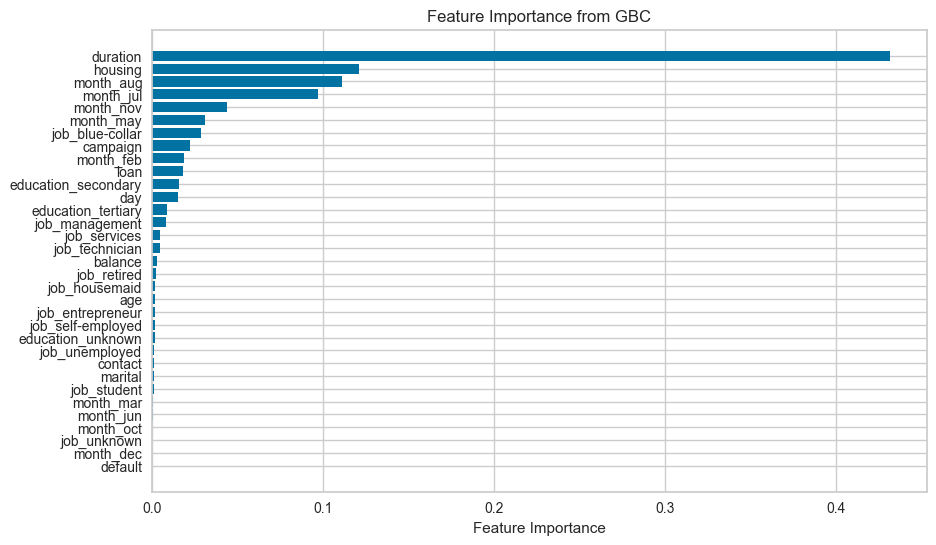

In [146]:
# Assuming X_train, y_train are already defined

# Initialize and fit the GBC model
gbc_model = GradientBoostingClassifier()
gbc_model.fit(X_resampled_df, y_resampled_df)

# Get feature importance
feature_importances = gbc_model.feature_importances_

# Create a DataFrame for better visualization
features = X_train.columns  # Make sure X_train is a DataFrame, else adjust accordingly
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Print the DataFrame
print(importance_df)

# Optionally, plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance from GBC')
plt.gca().invert_yaxis()
plt.show()

<h1>Summarizing Model Performance <h1>


<h3>Data: Imbalanced</h3>

<table>
  <tr>
    <th>Model</th>
    <th>Precision (class 1)</th>
    <th>Recall (class 1)</th>
  </tr>
  <tr>
    <td>RF</td>
    <td>62%</td>
    <td>14%</td>
  </tr>
  <tr>
    <td>XGB</td>
    <td>56%</td>
    <td>37%</td>
  </tr>
  <tr>
    <td>LGBM</td>
    <td>60%</td>
    <td>28%</td>
  </tr>
</table>
<br>
<br>
<h3>Data: Balanced with SMOTE-Tomek</h3>

<table>
  <tr>
    <th>Model</th>
    <th>Precision (class 1)</th>
    <th>Recall (class 1)</th>
  </tr>
  <tr>
    <td>RF</td>
    <td>44%</td>
    <td>34%</td>
  </tr>
  <tr>
    <td>XGB</td>
    <td>39%</td>
    <td>43%</td>
  </tr>
  <tr>
    <td>LGBM</td>
    <td>40%</td>
    <td>45%</td>
  </tr>
   <tr>
    <td>LogReg</td>
    <td>31%</td>
    <td>46%</td>
  </tr>
</table>
<br>
<br>
<h3>Data: Balanced with SMOTE-ENN</h3>

<table>
  <tr>
    <th>Model</th>
    <th>Precision (class 1)</th>
    <th>Recall (class 1)</th>
  </tr>
  <tr>
    <td>RF</td>
    <td>33%</td>
    <td>50%</td>
  </tr>
  <tr>
    <td>XGB</td>
    <td>32%</td>
    <td>64%</td>
  </tr>
  <tr>
    <td>LGBM</td>
    <td>30%</td>
    <td>63%</td>
  </tr>
</table>


Given our goal and business usecase XGB from SMOTE-ENN is the winner.

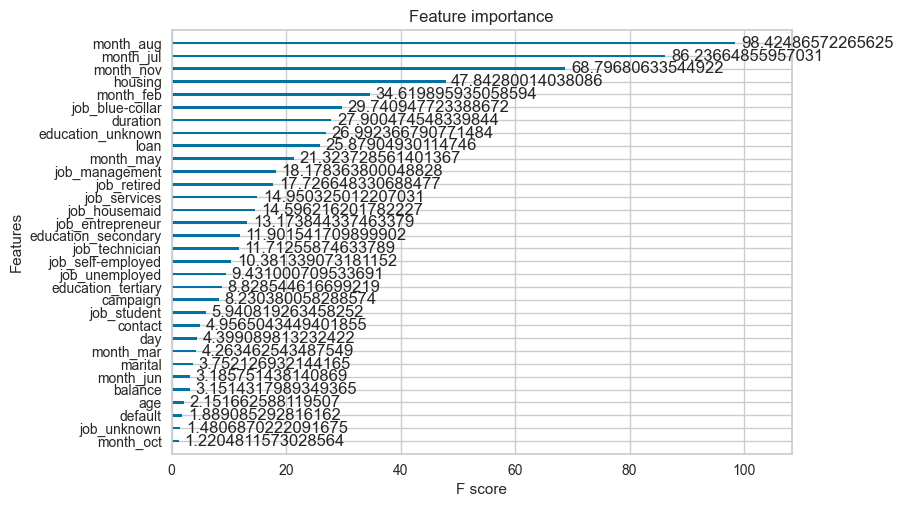

In [76]:
xgb.plot_importance(xgb_model,importance_type='gain')
plt.show()

In [77]:
from sklearn.feature_selection import RFE
# Create RFE with the model and specify the number of features to select
rfe = RFE(estimator=xgb_model)  # Change the number based on your needs

# Fit RFE
rfe.fit(X_resampled, y_resampled)

# Get the ranking of features
rankings = rfe.ranking_

# Get the selected features
selected_features = rfe.support_

print("Feature Ranking:", rankings)
print("Selected Features:", selected_features)

# Optional: Print the feature names if using a DataFrame
feature_names = X.columns
selected_feature_names = [name for name, selected in zip(feature_names, selected_features) if selected]
print("Selected Feature Names:", selected_feature_names)

Feature Ranking: [14 12 16 13  1  1  7 11  1  9  1  1  1  1  3  1  1  1  1  6 15  4  5  2
  1 18  1  1  8 10  1  1 17]
Selected Features: [False False False False  True  True False False  True False  True  True
  True  True False  True  True  True  True False False False False False
  True False  True  True False False  True  True False]
Selected Feature Names: ['housing', 'loan', 'duration', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'month_aug', 'month_feb', 'month_jul', 'month_may', 'month_nov']


Let's experiment with 2 sets of features, using SMOTE ENN balanced data, and see the results.
<br>
<br>
Feature Set 1: ['month_aug','month_july','month_nov','housing','month_feb','job_blue-collar','duration','education_uknown','loan']
<br>
<br>
Feature Set 2: ['housing', 'loan', 'duration', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'month_aug', 'month_feb', 'month_jul', 'month_may', 'month_nov']
<br>
<br>
Feature Set 3:
<br>
<br>
Feature Set 4:
<br>
<br>
Feature Set 5:
<br>
<br>
Feature Set 6:['duration','housing','month_aug','month_jul','month_nov','month_may','job_blue-collar','campaign','month_feb','loan','education_secondary','day','education_tertiary','job_management']




In [79]:
X_resampled.head()

,age,marital,default,balance,housing,loan,contact,day,duration,campaign,...,education_unknown,month_aug,month_dec,month_feb,month_jul,month_jun,month_mar,month_may,month_nov,month_oct
0,35,2,0,252,1,0,0,8,89,2,...,0,1,0,0,0,0,0,0,0,0
1,52,1,0,1023,0,0,0,7,107,6,...,0,0,0,0,1,0,0,0,0,0
2,40,1,0,99,0,0,0,9,15,5,...,0,0,0,1,0,0,0,0,0,0
3,29,1,0,97,1,0,0,13,431,2,...,0,0,0,0,0,0,0,1,0,0
4,54,1,0,217,0,0,1,17,110,2,...,1,0,0,0,0,0,0,0,1,0


<b> Experimenting with feature set 1 <b>

In [114]:
# List of required features
features_set_1 = ['month_aug', 'month_jul', 'month_nov', 'housing', 'month_feb', 
                     'job_blue-collar', 'duration', 'education_unknown', 'loan']

# Select these features from X_resampled and X_test
X_resampled_features_set_1  = X_resampled[features_set_1]
X_test_features_set_1  = X_test[features_set_1]


                 precision    recall  f1-score   support

Non-Subscribers       0.98      0.87      0.92      5552
    Subscribers       0.22      0.68      0.33       303

       accuracy                           0.86      5855
      macro avg       0.60      0.77      0.63      5855
   weighted avg       0.94      0.86      0.89      5855



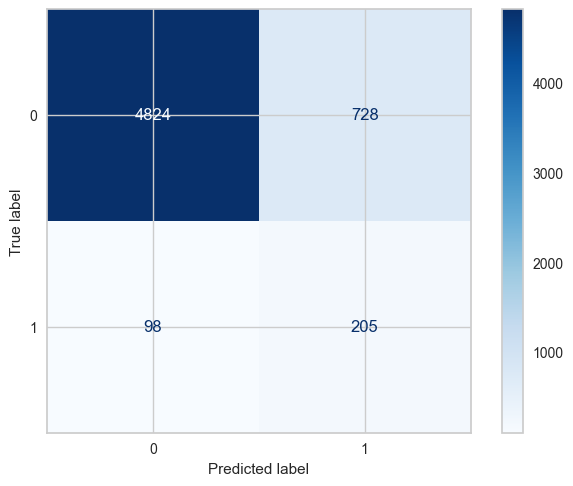

In [81]:

# Initialize the XGBoost classifier
xgb_model = XGBClassifier()
#train the model 
xgb_model.fit(X_resampled_features_set_1, y_resampled)
# Predict on the test set
y_pred = xgb_model.predict(X_test_features_set_1)
#Evaluate the model
print(classification_report(y_test, y_pred, target_names=target_names))
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()

In [115]:
# Initialize and fit LazyClassifier
clf = LazyClassifier()
models, predictions = clf.fit(X_resampled_features_set_1, X_test_features_set_1, y_resampled, y_test)

# View the performance comparison
print(models)

 97%|█████████▋| 28/29 [01:31<00:03,  3.92s/it]

[LightGBM] [Info] Number of positive: 11380, number of negative: 9229
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004956 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 279
[LightGBM] [Info] Number of data points in the train set: 20609, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552186 -> initscore=0.209507
[LightGBM] [Info] Start training from score 0.209507


100%|██████████| 29/29 [01:32<00:00,  3.18s/it]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
LinearDiscriminantAnalysis         0.83               0.79     0.79      0.88   
RidgeClassifierCV                  0.83               0.79     0.79      0.88   
RidgeClassifier                    0.83               0.79     0.79      0.88   
SVC                                0.85               0.79     0.79      0.89   
LGBMClassifier                     0.86               0.79     0.79      0.89   
SGDClassifier                      0.85               0.79     0.79      0.89   
CalibratedClassifierCV             0.85               0.79     0.79      0.88   
LogisticRegression                 0.84               0.79     0.79      0.88   
LinearSVC                          0.84               0.78     0.78      0.88   
AdaBoostClassifier                 0.85               0.78     0.78      0.89   
NearestCentroid             

[LightGBM] [Info] Number of positive: 11380, number of negative: 9229
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003933 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 273
[LightGBM] [Info] Number of data points in the train set: 20609, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552186 -> initscore=0.209507
[LightGBM] [Info] Start training from score 0.209507
                 precision    recall  f1-score   support

Non-Subscribers       0.98      0.86      0.92      5552
    Subscribers       0.22      0.75      0.34       303

       accuracy                           0.85      5855
      macro avg       0.60      0.80      0.63      5855
   weighted avg       0.94      0.85      0.89      5855



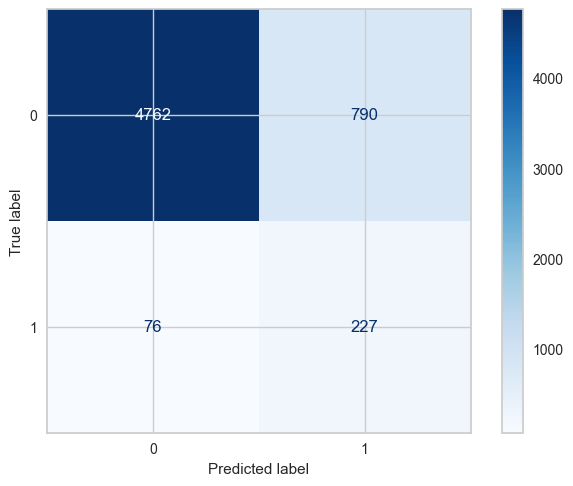

In [113]:
# Initialize LGBMClassifier
lgbm_model = lgb.LGBMClassifier()

# Fit the model with data
# Train the model
lgbm_model.fit(X_resampled_features_set_1, y_resampled)

# Predict on the test set
y_pred = lgbm_model.predict(X_test_features_set_1)

#Evaluate the model
print(classification_report(y_test, y_pred, target_names=target_names))
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()

                 precision    recall  f1-score   support

Non-Subscribers       0.98      0.84      0.91      5552
    Subscribers       0.20      0.75      0.32       303

       accuracy                           0.83      5855
      macro avg       0.59      0.79      0.61      5855
   weighted avg       0.94      0.83      0.88      5855



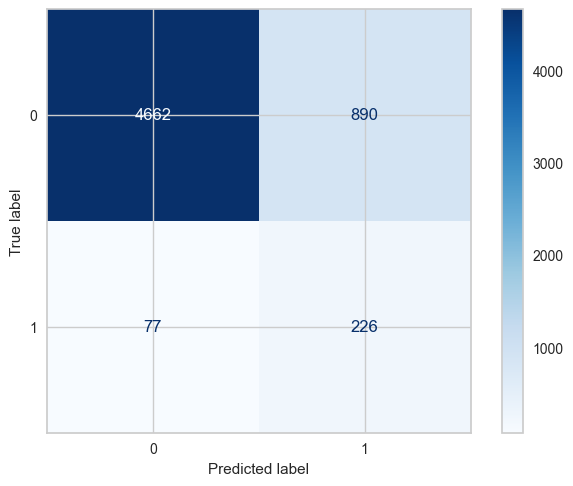

In [116]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


# Initialize the LDA model
lda_model = LinearDiscriminantAnalysis()

# Fit the model on the resampled training data
lda_model.fit(X_resampled_features_set_1, y_resampled)

# Predict on the test set
y_pred = lda_model.predict(X_test_features_set_1)

#Evaluate the model
print(classification_report(y_test, y_pred, target_names=target_names))
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()

                 precision    recall  f1-score   support

Non-Subscribers       0.98      0.84      0.91      5552
    Subscribers       0.20      0.75      0.32       303

       accuracy                           0.83      5855
      macro avg       0.59      0.79      0.61      5855
   weighted avg       0.94      0.83      0.88      5855



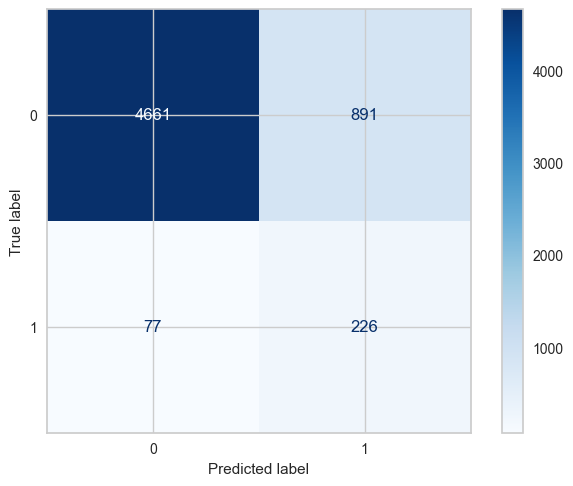

In [94]:
from sklearn.linear_model import RidgeClassifier

# Initialize the RidgeClassifier model
ridge_model = RidgeClassifier()

# Fit the model on the resampled training data
ridge_model.fit(X_resampled_features_set_1, y_resampled)

# Predict on the test set
y_pred = ridge_model.predict(X_test_features_set_1)

# Evaluate the model
print(classification_report(y_test, y_pred, target_names=target_names))
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()


                 precision    recall  f1-score   support

Non-Subscribers       0.97      0.80      0.88      5552
    Subscribers       0.13      0.57      0.21       303

       accuracy                           0.79      5855
      macro avg       0.55      0.68      0.55      5855
   weighted avg       0.93      0.79      0.84      5855



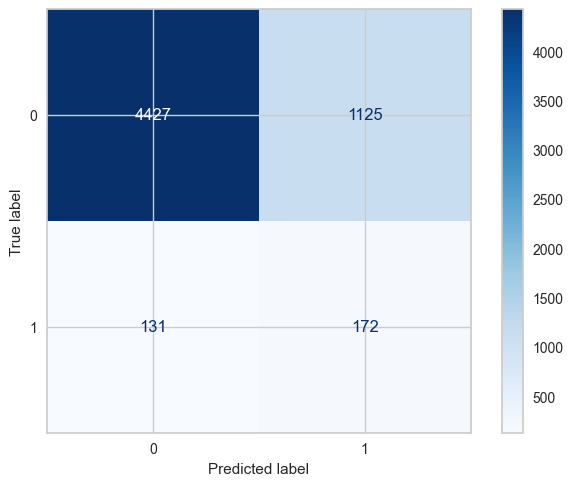

In [95]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


# Initialize the QDA model
qda_model = QuadraticDiscriminantAnalysis()

# Fit the model on the resampled training data
qda_model.fit(X_resampled_features_set_1, y_resampled)

# Predict on the test set
y_pred = qda_model.predict(X_test_features_set_1)

# Evaluate the model
print(classification_report(y_test, y_pred, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()


                 precision    recall  f1-score   support

Non-Subscribers       0.98      0.84      0.91      5552
    Subscribers       0.20      0.75      0.32       303

       accuracy                           0.83      5855
      macro avg       0.59      0.79      0.61      5855
   weighted avg       0.94      0.83      0.88      5855



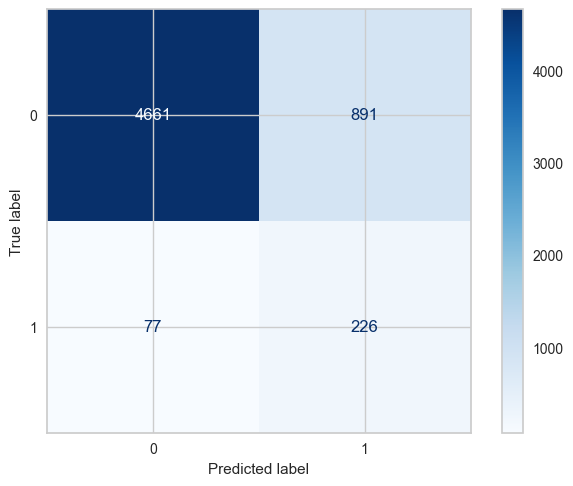

In [96]:
from sklearn.linear_model import RidgeClassifierCV

# Initialize the RidgeClassifierCV model
ridge_cv_model = RidgeClassifierCV()

# Fit the model on the resampled training data
ridge_cv_model.fit(X_resampled_features_set_1, y_resampled)

# Predict on the test set
y_pred = ridge_cv_model.predict(X_test_features_set_1)

# Evaluate the model
print(classification_report(y_test, y_pred, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()


                 precision    recall  f1-score   support

Non-Subscribers       0.98      0.87      0.92      5552
    Subscribers       0.23      0.70      0.34       303

       accuracy                           0.86      5855
      macro avg       0.60      0.79      0.63      5855
   weighted avg       0.94      0.86      0.89      5855



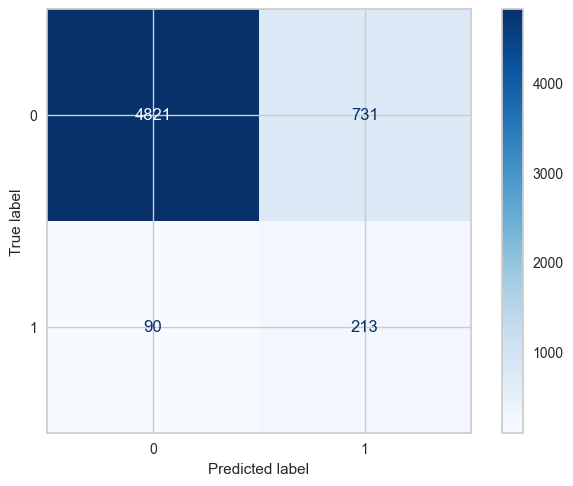

In [107]:
# Initialize the RandomForestClassifier
rf_model = RandomForestClassifier(bootstrap=True, criterion="gini", max_features=0.2, min_samples_leaf=14, min_samples_split=4, n_estimators=100)
# Train the model
rf_model.fit(X_resampled_features_set_1, y_resampled)
# Predict on the test set
y_pred = rf_model.predict(X_test_features_set_1)
#Evaluate the model
print(classification_report(y_test, y_pred, target_names=target_names))
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()

<b> Experimenting with Feature Set 2 <b>

                 precision    recall  f1-score   support

Non-Subscribers       0.98      0.90      0.94      5552
    Subscribers       0.25      0.63      0.36       303

       accuracy                           0.88      5855
      macro avg       0.61      0.76      0.65      5855
   weighted avg       0.94      0.88      0.91      5855



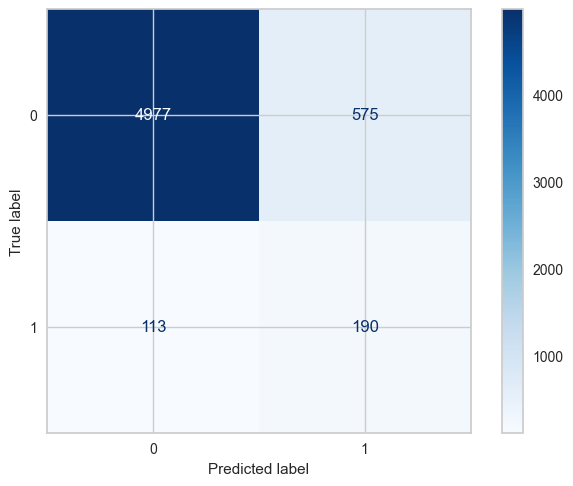

In [82]:
features_set_2= ['housing', 'loan', 'duration', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'month_aug', 'month_feb', 'month_jul', 'month_may', 'month_nov']

# Select these features from X_resampled and X_test
X_resampled_features_set_2  = X_resampled[features_set_2]
X_test_features_set_2  = X_test[features_set_2]

# Initialize the XGBoost classifier
xgb_model = XGBClassifier()
#train the model 
xgb_model.fit(X_resampled_features_set_2, y_resampled)
# Predict on the test set
y_pred = xgb_model.predict(X_test_features_set_2)
#Evaluate the model
print(classification_report(y_test, y_pred, target_names=target_names))
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()



In [84]:
# Initialize and fit LazyClassifier
clf = LazyClassifier()
models, predictions = clf.fit(X_resampled_features_set_2, X_test_features_set_2, y_resampled, y_test)

# View the performance comparison
print(models)

 97%|█████████▋| 28/29 [01:31<00:03,  3.68s/it]

[LightGBM] [Info] Number of positive: 11380, number of negative: 9229
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 300
[LightGBM] [Info] Number of data points in the train set: 20609, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552186 -> initscore=0.209507
[LightGBM] [Info] Start training from score 0.209507


100%|██████████| 29/29 [01:32<00:00,  3.20s/it]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
AdaBoostClassifier                 0.88               0.78     0.78      0.90   
LGBMClassifier                     0.88               0.77     0.77      0.91   
LogisticRegression                 0.88               0.77     0.77      0.90   
LinearSVC                          0.88               0.77     0.77      0.90   
XGBClassifier                      0.88               0.76     0.76      0.91   
PassiveAggressiveClassifier        0.81               0.75     0.75      0.86   
CalibratedClassifierCV             0.89               0.75     0.75      0.91   
SVC                                0.89               0.75     0.75      0.91   
ExtraTreesClassifier               0.88               0.74     0.74      0.90   
NearestCentroid                    0.88               0.74     0.74      0.90   
RandomForestClassifier      

[LightGBM] [Info] Number of positive: 11380, number of negative: 9229
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 285
[LightGBM] [Info] Number of data points in the train set: 20609, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552186 -> initscore=0.209507
[LightGBM] [Info] Start training from score 0.209507
                 precision    recall  f1-score   support

Non-Subscribers       0.98      0.90      0.94      5552
    Subscribers       0.26      0.64      0.37       303

       accuracy                           0.88      5855
      macro avg       0.62      0.77      0.65      5855
   weighted avg       0.94      0.88      0.91      5855



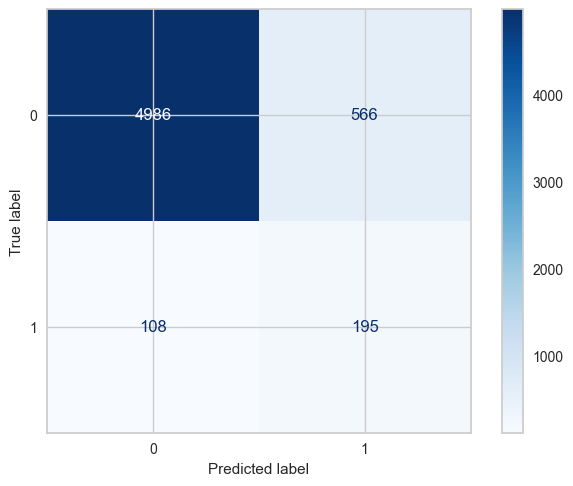

In [98]:
# Initialize the LightGBM classifier
lgbm_model = lgb.LGBMClassifier()

# Train the model
lgbm_model.fit(X_resampled_features_set_2, y_resampled)

# Predict on the test set
y_pred = lgbm_model.predict(X_test_features_set_2)

# Evaluate the model
print(classification_report(y_test, y_pred, target_names=target_names))
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()

                 precision    recall  f1-score   support

Non-Subscribers       0.98      0.88      0.93      5552
    Subscribers       0.24      0.72      0.36       303

       accuracy                           0.87      5855
      macro avg       0.61      0.80      0.65      5855
   weighted avg       0.94      0.87      0.90      5855



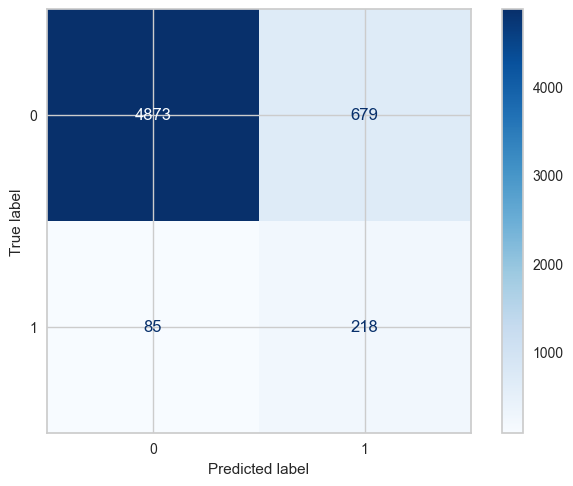

In [99]:


# Initialize the Gradient Boosting classifier
gbc_model = GradientBoostingClassifier()

# Train the model
gbc_model.fit(X_resampled_features_set_2, y_resampled)

# Predict on the test set
y_pred = gbc_model.predict(X_test_features_set_2)

# Evaluate the model
print(classification_report(y_test, y_pred, target_names=target_names))
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()


                 precision    recall  f1-score   support

Non-Subscribers       0.97      0.84      0.90      5552
    Subscribers       0.16      0.54      0.24       303

       accuracy                           0.82      5855
      macro avg       0.56      0.69      0.57      5855
   weighted avg       0.93      0.82      0.87      5855



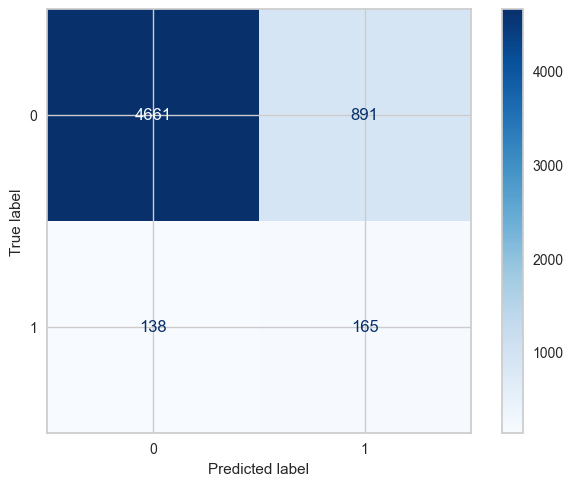

In [100]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# Initialize the QDA model
qda_model = QuadraticDiscriminantAnalysis()

# Train the model
qda_model.fit(X_resampled_features_set_2, y_resampled)

# Predict on the test set
y_pred = qda_model.predict(X_test_features_set_2)

# Evaluate the model
print(classification_report(y_test, y_pred, target_names=target_names))
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()

                 precision    recall  f1-score   support

Non-Subscribers       0.98      0.89      0.93      5552
    Subscribers       0.25      0.66      0.36       303

       accuracy                           0.88      5855
      macro avg       0.62      0.78      0.65      5855
   weighted avg       0.94      0.88      0.90      5855



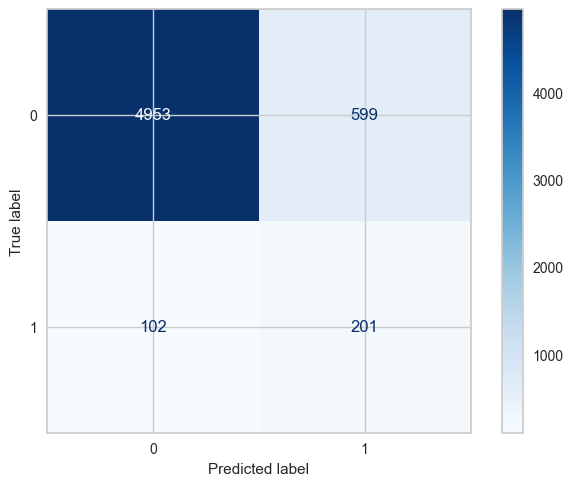

In [101]:
from sklearn.ensemble import AdaBoostClassifier

# Initialize the AdaBoost classifier
ada_model = AdaBoostClassifier()

# Train the model
ada_model.fit(X_resampled_features_set_2, y_resampled)

# Predict on the test set
y_pred = ada_model.predict(X_test_features_set_2)

# Evaluate the model
print(classification_report(y_test, y_pred, target_names=target_names))
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()


In [86]:
# Load dataset and initialize PyCaret
clf = setup(data=pd.concat([data_cleaned_filtered_transformed[features_set_1], 
                            data_cleaned_filtered_transformed[['y']]], axis=1), 
            target='y')
# Compare models and select the best
best_model = compare_models()

# Tune the best model
tuned_model = tune_model(best_model)

,Description,Value
0,Session id,2392
1,Target,y
2,Target type,Binary
3,Original data shape,"(19515, 10)"
4,Transformed data shape,"(19515, 10)"
5,Transformed train set shape,"(13660, 10)"
6,Transformed test set shape,"(5855, 10)"
7,Numeric features,9
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.9478,0.8794,0.0000,0.0000,0.0000,0.0000,0.0000,0.0480
dummy,Dummy Classifier,0.9478,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0860
gbc,Gradient Boosting Classifier,0.9475,0.8895,0.0660,0.4844,0.1158,0.1046,0.1638,1.2740
lr,Logistic Regression,0.9472,0.8805,0.0814,0.4736,0.1378,0.1245,0.1787,4.1500
lda,Linear Discriminant Analysis,0.9457,0.8794,0.1587,0.4468,0.2332,0.2117,0.2431,0.0950
ada,Ada Boost Classifier,0.9441,0.8818,0.1067,0.3765,0.1655,0.1460,0.1781,0.8980
lightgbm,Light Gradient Boosting Machine,0.9430,0.8792,0.0700,0.3119,0.1139,0.0962,0.1263,0.5210
knn,K Neighbors Classifier,0.9395,0.6964,0.0504,0.1974,0.0791,0.0592,0.0747,0.1930
rf,Random Forest Classifier,0.9310,0.7723,0.2048,0.2791,0.2358,0.2006,0.2035,0.8040
et,Extra Trees Classifier,0.9300,0.6822,0.1880,0.2613,0.2180,0.1826,0.1856,1.3370


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9480,0.7030,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.9480,0.6763,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.9480,0.7396,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.9480,0.6977,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.9480,0.7092,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.9480,0.6828,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.9480,0.7172,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.9473,0.7045,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.9473,0.6353,0.0000,0.0000,0.0000,0.0000,0.0000


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [87]:
# Load dataset and initialize PyCaret
clf = setup(data=pd.concat([data_cleaned_filtered_transformed[features_set_2], 
                            data_cleaned_filtered_transformed[['y']]], axis=1), 
            target='y')
# Compare models and select the best
best_model = compare_models()

# Tune the best model
tuned_model = tune_model(best_model)

,Description,Value
0,Session id,8087
1,Target,y
2,Target type,Binary
3,Original data shape,"(19515, 17)"
4,Transformed data shape,"(19515, 17)"
5,Transformed train set shape,"(13660, 17)"
6,Transformed test set shape,"(5855, 17)"
7,Numeric features,16
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9490,0.8932,0.1964,0.5401,0.2857,0.2652,0.3032,0.2980
gbc,Gradient Boosting Classifier,0.9485,0.8979,0.0953,0.5412,0.1608,0.1476,0.2101,1.0940
lr,Logistic Regression,0.9483,0.8886,0.1219,0.5282,0.1962,0.1802,0.2343,0.4260
ridge,Ridge Classifier,0.9478,0.8853,0.0000,0.0000,0.0000,0.0000,0.0000,0.0620
dummy,Dummy Classifier,0.9478,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0470
ada,Ada Boost Classifier,0.9448,0.8868,0.1163,0.4074,0.1792,0.1597,0.1948,0.4370
knn,K Neighbors Classifier,0.9430,0.6942,0.0603,0.2881,0.0993,0.0825,0.1108,0.4860
lda,Linear Discriminant Analysis,0.9430,0.8851,0.2173,0.4146,0.2841,0.2574,0.2726,0.0940
rf,Random Forest Classifier,0.9292,0.8082,0.2229,0.2781,0.2471,0.2105,0.2120,0.9140
et,Extra Trees Classifier,0.9251,0.7193,0.2412,0.2636,0.2513,0.2121,0.2125,1.1330


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9561,0.8976,0.1972,0.8235,0.3182,0.3042,0.3902
1,0.9429,0.8889,0.0704,0.2941,0.1136,0.0955,0.1225
2,0.9510,0.9175,0.1549,0.6111,0.2472,0.2310,0.2911
3,0.9517,0.8905,0.1549,0.6471,0.2500,0.2346,0.3009
4,0.9517,0.9021,0.1831,0.6190,0.2826,0.2652,0.3192
5,0.9539,0.9095,0.2113,0.6818,0.3226,0.3055,0.3630
6,0.9502,0.8797,0.1831,0.5652,0.2766,0.2577,0.3026
7,0.9502,0.9075,0.1667,0.6000,0.2609,0.2435,0.2986
8,0.9495,0.8833,0.1944,0.5600,0.2887,0.2688,0.3100


Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [88]:
best_model

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=8087, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

<b>Experimenting with Feature Set 3 <b>

In [117]:
# List of required features
features_set_3 = ['month_aug', 'month_jul', 'month_nov', 'housing', 'month_feb', 
                     'job_blue-collar', 'duration', 'education_unknown', 'loan','month_may']

# Select these features from X_resampled and X_test
X_resampled_features_set_3  = X_resampled[features_set_3]
X_test_features_set_3  = X_test[features_set_3]

In [118]:
# Initialize and fit LazyClassifier
clf = LazyClassifier()
models, predictions = clf.fit(X_resampled_features_set_3, X_test_features_set_3, y_resampled, y_test)

# View the performance comparison
print(models)

 97%|█████████▋| 28/29 [02:15<00:05,  5.79s/it]

[LightGBM] [Info] Number of positive: 11380, number of negative: 9229
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004383 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 20609, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552186 -> initscore=0.209507
[LightGBM] [Info] Start training from score 0.209507


100%|██████████| 29/29 [02:16<00:00,  4.72s/it]


                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
LGBMClassifier                     0.85               0.80     0.80      0.89   
SVC                                0.86               0.80     0.80      0.89   
LogisticRegression                 0.86               0.79     0.79      0.89   
LinearSVC                          0.86               0.79     0.79      0.89   
Perceptron                         0.81               0.79     0.79      0.86   
PassiveAggressiveClassifier        0.75               0.79     0.79      0.82   
AdaBoostClassifier                 0.85               0.79     0.79      0.89   
XGBClassifier                      0.86               0.79     0.79      0.89   
CalibratedClassifierCV             0.86               0.78     0.78      0.89   
NearestCentroid                    0.85               0.77     0.77      0.88   
KNeighborsClassifier        

In [120]:
# Load dataset and initialize PyCaret
clf = setup(data=pd.concat([data_cleaned_filtered_transformed[features_set_3], 
                            data_cleaned_filtered_transformed[['y']]], axis=1), 
            target='y')
# Compare models and select the best
best_model = compare_models()

# Tune the best model
tuned_model = tune_model(best_model)

,Description,Value
0,Session id,1925
1,Target,y
2,Target type,Binary
3,Original data shape,"(19515, 11)"
4,Transformed data shape,"(19515, 11)"
5,Transformed train set shape,"(13660, 11)"
6,Transformed test set shape,"(5855, 11)"
7,Numeric features,10
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.9497,0.8994,0.0997,0.6051,0.1703,0.1582,0.2303,0.7260
lightgbm,Light Gradient Boosting Machine,0.9485,0.8877,0.1978,0.5170,0.2827,0.2619,0.2963,0.4140
lr,Logistic Regression,0.9480,0.8916,0.1165,0.5048,0.1883,0.1725,0.2238,4.4150
ridge,Ridge Classifier,0.9478,0.8878,0.0000,0.0000,0.0000,0.0000,0.0000,0.0930
dummy,Dummy Classifier,0.9478,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0610
ada,Ada Boost Classifier,0.9444,0.8933,0.1347,0.4039,0.2009,0.1797,0.2097,0.4110
lda,Linear Discriminant Analysis,0.9430,0.8877,0.1880,0.4045,0.2558,0.2302,0.2491,0.0640
knn,K Neighbors Classifier,0.9408,0.7065,0.0505,0.2418,0.0822,0.0638,0.0866,0.2100
rf,Random Forest Classifier,0.9314,0.7841,0.2329,0.2991,0.2612,0.2259,0.2282,0.7510
dt,Decision Tree Classifier,0.9302,0.6270,0.2287,0.2858,0.2534,0.2174,0.2192,0.0620


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9466,0.9132,0.0986,0.4375,0.1609,0.1446,0.1891
1,0.9546,0.9248,0.2817,0.6452,0.3922,0.3723,0.4072
2,0.9546,0.9075,0.1690,0.8000,0.2791,0.2658,0.3551
3,0.9517,0.8851,0.1268,0.6923,0.2143,0.2014,0.2828
4,0.9466,0.8847,0.1549,0.4583,0.2316,0.2109,0.2448
5,0.9466,0.9058,0.1549,0.4583,0.2316,0.2109,0.2448
6,0.9480,0.9029,0.1549,0.5000,0.2366,0.2173,0.2582
7,0.9524,0.8868,0.1667,0.7059,0.2697,0.2547,0.3281
8,0.9524,0.8907,0.1944,0.6667,0.3011,0.2840,0.3433


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[LightGBM] [Info] Number of positive: 11380, number of negative: 9229
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004723 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 273
[LightGBM] [Info] Number of data points in the train set: 20609, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552186 -> initscore=0.209507
[LightGBM] [Info] Start training from score 0.209507
                 precision    recall  f1-score   support

Non-Subscribers       0.98      0.86      0.92      5552
    Subscribers       0.22      0.75      0.34       303

       accuracy                           0.85      5855
      macro avg       0.60      0.80      0.63      5855
   weighted avg       0.94      0.85      0.89      5855



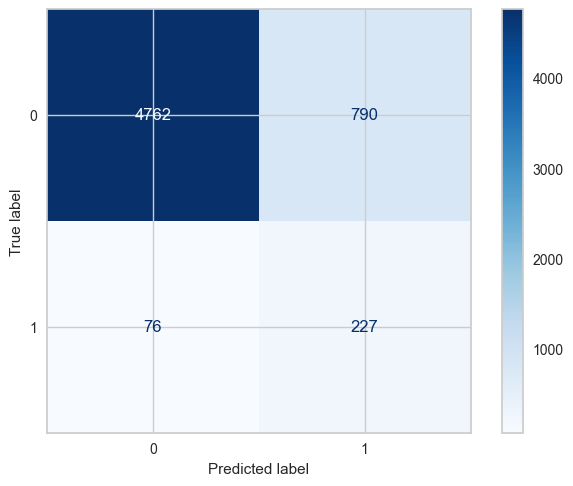

In [119]:
# Initialize the LightGBM classifier
lgbm_model = lgb.LGBMClassifier()

# Train the model
lgbm_model.fit(X_resampled_features_set_3, y_resampled)

# Predict on the test set
y_pred = lgbm_model.predict(X_test_features_set_3)

# Evaluate the model
print(classification_report(y_test, y_pred, target_names=target_names))
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()

                 precision    recall  f1-score   support

Non-Subscribers       0.99      0.85      0.91      5552
    Subscribers       0.22      0.79      0.34       303

       accuracy                           0.85      5855
      macro avg       0.60      0.82      0.63      5855
   weighted avg       0.95      0.85      0.88      5855



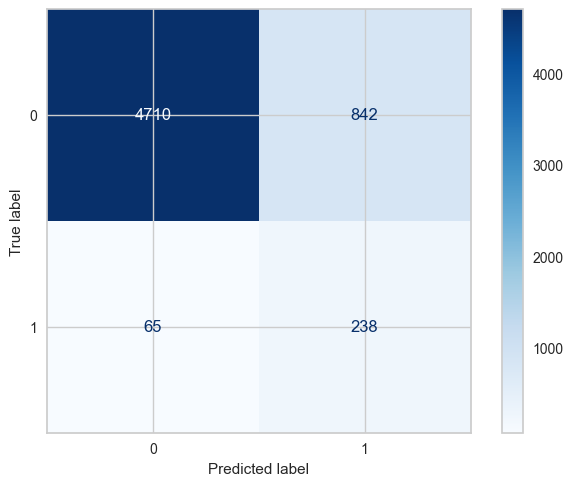

In [121]:
# Initialize the Gradient Boosting classifier
gbc_model = GradientBoostingClassifier()

# Train the model
gbc_model.fit(X_resampled_features_set_3, y_resampled)

# Predict on the test set
y_pred = gbc_model.predict(X_test_features_set_3)

# Evaluate the model
print(classification_report(y_test, y_pred, target_names=target_names))
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()

<b> Experimenting with feature set 4 <b>

In [123]:
# List of required features
features_set_4 = ['month_aug', 'month_jul', 'month_nov', 'housing', 'month_feb', 
                     'job_blue-collar', 'duration', 'education_unknown', 'loan','month_may','job_management']

# Select these features from X_resampled and X_test
X_resampled_features_set_4  = X_resampled[features_set_4]
X_test_features_set_4  = X_test[features_set_4]


In [124]:
# Initialize and fit LazyClassifier
clf = LazyClassifier()
models, predictions = clf.fit(X_resampled_features_set_4, X_test_features_set_4, y_resampled, y_test)

# View the performance comparison
print(models)

 97%|█████████▋| 28/29 [01:43<00:03,  3.60s/it]

[LightGBM] [Info] Number of positive: 11380, number of negative: 9229
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005683 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 285
[LightGBM] [Info] Number of data points in the train set: 20609, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552186 -> initscore=0.209507
[LightGBM] [Info] Start training from score 0.209507


100%|██████████| 29/29 [01:44<00:00,  3.60s/it]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
Perceptron                         0.80               0.80     0.80      0.85   
LGBMClassifier                     0.86               0.79     0.79      0.89   
SVC                                0.86               0.79     0.79      0.89   
LogisticRegression                 0.86               0.79     0.79      0.89   
LinearSVC                          0.86               0.79     0.79      0.89   
PassiveAggressiveClassifier        0.76               0.78     0.78      0.82   
AdaBoostClassifier                 0.86               0.78     0.78      0.89   
CalibratedClassifierCV             0.87               0.78     0.78      0.90   
SGDClassifier                      0.86               0.78     0.78      0.89   
XGBClassifier                      0.86               0.77     0.77      0.89   
NearestCentroid             

In [125]:
# Load dataset and initialize PyCaret
clf = setup(data=pd.concat([data_cleaned_filtered_transformed[features_set_4], 
                            data_cleaned_filtered_transformed[['y']]], axis=1), 
            target='y')
# Compare models and select the best
best_model = compare_models()

# Tune the best model
tuned_model = tune_model(best_model)

,Description,Value
0,Session id,3980
1,Target,y
2,Target type,Binary
3,Original data shape,"(19515, 12)"
4,Transformed data shape,"(19515, 12)"
5,Transformed train set shape,"(13660, 12)"
6,Transformed test set shape,"(5855, 12)"
7,Numeric features,11
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.9491,0.9028,0.0995,0.6017,0.1691,0.1563,0.2279,1.1730
ridge,Ridge Classifier,0.9478,0.8919,0.0000,0.0000,0.0000,0.0000,0.0000,0.1710
dummy,Dummy Classifier,0.9478,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0530
lr,Logistic Regression,0.9475,0.8948,0.1234,0.5008,0.1958,0.1788,0.2280,2.2450
lightgbm,Light Gradient Boosting Machine,0.9475,0.8912,0.1585,0.4985,0.2384,0.2187,0.2589,0.3310
ada,Ada Boost Classifier,0.9441,0.8898,0.1360,0.4066,0.2024,0.1807,0.2111,1.1180
lda,Linear Discriminant Analysis,0.9433,0.8918,0.2132,0.4250,0.2811,0.2550,0.2730,0.1760
knn,K Neighbors Classifier,0.9421,0.6898,0.0673,0.2865,0.1083,0.0898,0.1163,0.2480
rf,Random Forest Classifier,0.9311,0.8033,0.2371,0.2984,0.2640,0.2284,0.2302,1.3560
et,Extra Trees Classifier,0.9300,0.7197,0.2399,0.2914,0.2629,0.2266,0.2279,1.0640


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9458,0.8923,0.1268,0.4286,0.1957,0.1761,0.2120
1,0.9561,0.8752,0.2958,0.6774,0.4118,0.3926,0.4294
2,0.9488,0.9292,0.1127,0.5333,0.1860,0.1710,0.2285
3,0.9495,0.9126,0.1549,0.5500,0.2418,0.2240,0.2735
4,0.9524,0.9038,0.1549,0.6875,0.2529,0.2383,0.3117
5,0.9451,0.8815,0.1690,0.4286,0.2424,0.2195,0.2454
6,0.9444,0.9042,0.1549,0.4074,0.2245,0.2016,0.2274
7,0.9546,0.9063,0.2222,0.7273,0.3404,0.3237,0.3862
8,0.9488,0.8812,0.1528,0.5500,0.2391,0.2213,0.2713


Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [128]:
best_model

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='log_loss', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=100, n_iter_no_change=None,
                           random_state=3980, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

                 precision    recall  f1-score   support

Non-Subscribers       0.98      0.90      0.93      5552
    Subscribers       0.24      0.59      0.34       303

       accuracy                           0.88      5855
      macro avg       0.61      0.74      0.64      5855
   weighted avg       0.94      0.88      0.90      5855



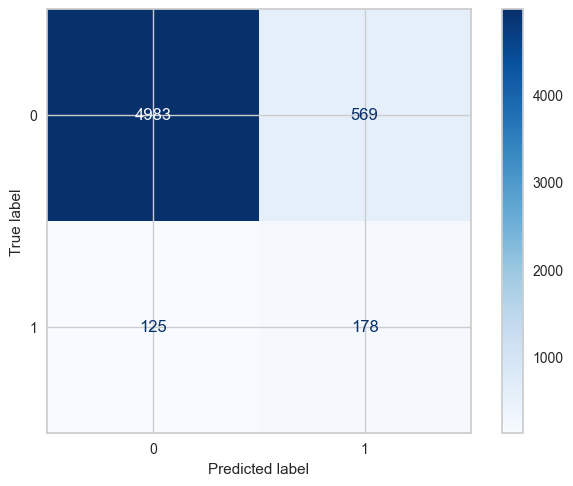

In [126]:
from sklearn.linear_model import Perceptron

# Initialize the Perceptron model
perceptron = Perceptron()

# Train the model
perceptron.fit(X_resampled_features_set_4, y_resampled)
# Predict on the test set
y_pred = perceptron.predict(X_test_features_set_4)

# Evaluate the model
print(classification_report(y_test, y_pred, target_names=target_names))
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()


                 precision    recall  f1-score   support

Non-Subscribers       0.99      0.85      0.91      5552
    Subscribers       0.22      0.77      0.34       303

       accuracy                           0.84      5855
      macro avg       0.60      0.81      0.62      5855
   weighted avg       0.95      0.84      0.88      5855



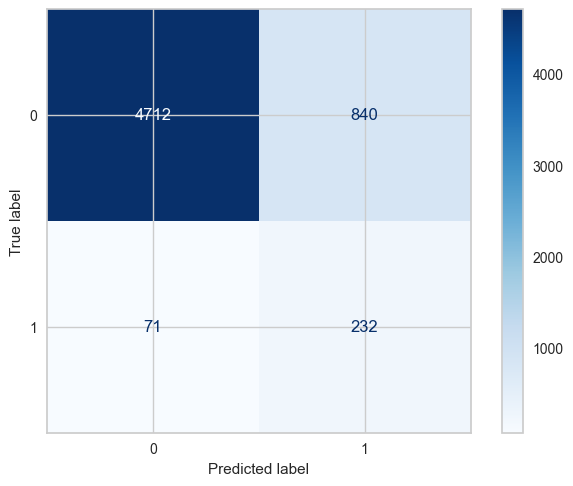

In [129]:
# Initialize the Gradient Boosting classifier
gbc_model = GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='log_loss', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=100, n_iter_no_change=None,
                           random_state=3980, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

# Train the model
gbc_model.fit(X_resampled_features_set_4, y_resampled)

# Predict on the test set
y_pred = gbc_model.predict(X_test_features_set_4)

# Evaluate the model
print(classification_report(y_test, y_pred, target_names=target_names))
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()

                 precision    recall  f1-score   support

Non-Subscribers       0.98      0.88      0.93      5552
    Subscribers       0.23      0.64      0.34       303

       accuracy                           0.87      5855
      macro avg       0.60      0.76      0.63      5855
   weighted avg       0.94      0.87      0.90      5855



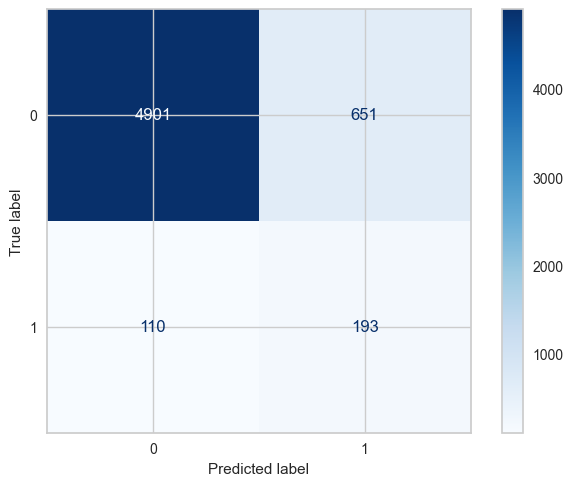

In [130]:
# Initialize the RidgeClassifier model
ridge_model = RidgeClassifier()

# Fit the model on the resampled training data
ridge_model.fit(X_resampled_features_set_4, y_resampled)

# Predict on the test set
y_pred = ridge_model.predict(X_test_features_set_4)

# Evaluate the model
print(classification_report(y_test, y_pred, target_names=target_names))
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()

<b> Experimenting with Feature Set 5 <b>

In [131]:
# List of required features
features_set_5 = ['month_aug', 'month_jul', 'month_nov', 'housing', 'month_feb', 
                     'job_blue-collar', 'duration', 'education_unknown', 'loan','month_may','job_management','job_retired']

# Select these features from X_resampled and X_test
X_resampled_features_set_5  = X_resampled[features_set_5]
X_test_features_set_5  = X_test[features_set_5]


In [134]:
# Load dataset and initialize PyCaret
clf = setup(data=pd.concat([data_cleaned_filtered_transformed[features_set_5], 
                            data_cleaned_filtered_transformed[['y']]], axis=1), 
            target='y')
# Compare models and select the best
best_model = compare_models()

# Tune the best model
tuned_model = tune_model(best_model)

,Description,Value
0,Session id,7874
1,Target,y
2,Target type,Binary
3,Original data shape,"(19515, 13)"
4,Transformed data shape,"(19515, 13)"
5,Transformed train set shape,"(13660, 13)"
6,Transformed test set shape,"(5855, 13)"
7,Numeric features,12
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.9487,0.8952,0.0883,0.5729,0.1521,0.1398,0.2090,0.9240
lightgbm,Light Gradient Boosting Machine,0.9484,0.8878,0.1556,0.5158,0.2379,0.2193,0.2628,0.6240
ridge,Ridge Classifier,0.9478,0.8834,0.0000,0.0000,0.0000,0.0000,0.0000,0.0910
dummy,Dummy Classifier,0.9478,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0620
lr,Logistic Regression,0.9469,0.8857,0.0926,0.4750,0.1542,0.1392,0.1915,1.9080
ada,Ada Boost Classifier,0.9439,0.8870,0.1079,0.3817,0.1661,0.1463,0.1790,0.4550
knn,K Neighbors Classifier,0.9426,0.6770,0.0364,0.2016,0.0609,0.0465,0.0653,0.2680
lda,Linear Discriminant Analysis,0.9415,0.8833,0.1627,0.3656,0.2247,0.1990,0.2170,0.0960
rf,Random Forest Classifier,0.9302,0.7904,0.2383,0.2914,0.2614,0.2253,0.2269,0.8140
et,Extra Trees Classifier,0.9290,0.7015,0.2397,0.2850,0.2594,0.2226,0.2239,1.2290


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9466,0.8549,0.0423,0.3750,0.0759,0.0661,0.1117
1,0.9480,0.8921,0.0423,0.5000,0.0779,0.0704,0.1341
2,0.9480,0.8574,0.0704,0.5000,0.1235,0.1121,0.1733
3,0.9510,0.9007,0.0845,0.7500,0.1519,0.1429,0.2414
4,0.9480,0.8992,0.0563,0.5000,0.1013,0.0917,0.1549
5,0.9539,0.8941,0.1127,1.0000,0.2025,0.1940,0.3278
6,0.9510,0.9019,0.0845,0.7500,0.1519,0.1429,0.2414
7,0.9473,0.8957,0.0694,0.5000,0.1220,0.1105,0.1719
8,0.9473,0.8863,0.0694,0.5000,0.1220,0.1105,0.1719


Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [137]:
best_model

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='log_loss', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=100, n_iter_no_change=None,
                           random_state=7874, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [133]:
# Initialize and fit LazyClassifier
clf = LazyClassifier()
models, predictions = clf.fit(X_resampled_features_set_5, X_test_features_set_5, y_resampled, y_test)

# View the performance comparison
print(models)

  0%|          | 0/29 [00:00<?, ?it/s]

 97%|█████████▋| 28/29 [01:49<00:03,  3.74s/it]

[LightGBM] [Info] Number of positive: 11380, number of negative: 9229
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 288
[LightGBM] [Info] Number of data points in the train set: 20609, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552186 -> initscore=0.209507
[LightGBM] [Info] Start training from score 0.209507


100%|██████████| 29/29 [01:50<00:00,  3.81s/it]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
LogisticRegression                 0.87               0.79     0.79      0.90   
LGBMClassifier                     0.86               0.79     0.79      0.89   
AdaBoostClassifier                 0.86               0.79     0.79      0.89   
SVC                                0.86               0.79     0.79      0.89   
LinearSVC                          0.86               0.79     0.79      0.89   
CalibratedClassifierCV             0.87               0.78     0.78      0.90   
XGBClassifier                      0.86               0.78     0.78      0.89   
PassiveAggressiveClassifier        0.77               0.78     0.78      0.83   
Perceptron                         0.82               0.77     0.77      0.86   
ExtraTreesClassifier               0.87               0.77     0.77      0.90   
NearestCentroid             

                 precision    recall  f1-score   support

Non-Subscribers       0.98      0.87      0.92      5552
    Subscribers       0.23      0.71      0.35       303

       accuracy                           0.86      5855
      macro avg       0.61      0.79      0.64      5855
   weighted avg       0.94      0.86      0.89      5855



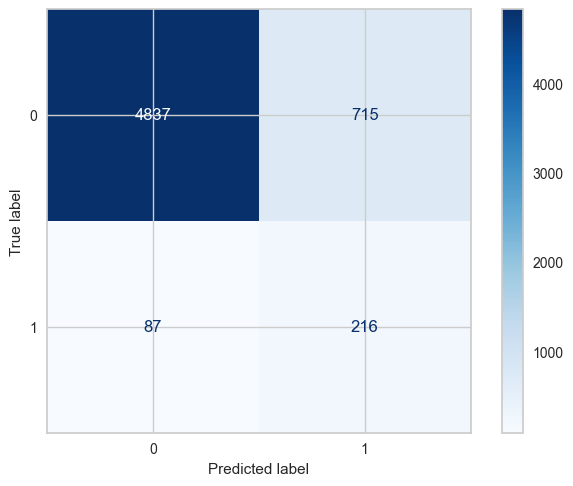

In [135]:
# instantiate the model
logreg = LogisticRegression(solver='liblinear', random_state=0)

# fit the model
logreg.fit(X_resampled_features_set_5, y_resampled)

# Predict on the test set
y_pred = logreg.predict(X_test_features_set_5)
#Evaluate the model
print(classification_report(y_test, y_pred, target_names=target_names))
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()

                 precision    recall  f1-score   support

Non-Subscribers       0.98      0.85      0.91      5552
    Subscribers       0.22      0.75      0.34       303

       accuracy                           0.85      5855
      macro avg       0.60      0.80      0.63      5855
   weighted avg       0.94      0.85      0.88      5855



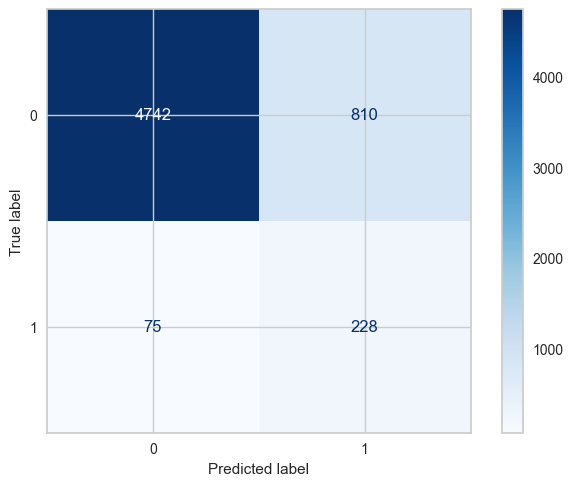

In [138]:
# Initialize the Gradient Boosting classifier
gbc_model = GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='log_loss', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=100, n_iter_no_change=None,
                           random_state=7874, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

# Train the model
gbc_model.fit(X_resampled_features_set_5, y_resampled)

# Predict on the test set
y_pred = gbc_model.predict(X_test_features_set_5)

# Evaluate the model
print(classification_report(y_test, y_pred, target_names=target_names))
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()

<b> Experimenting with Feature Set 6 </b>

In [148]:
features_set_6=['duration','housing','month_aug','month_jul','month_nov','month_may','job_blue-collar','campaign','month_feb','loan','education_secondary','day','education_tertiary','job_management']

# Select these features from X_resampled and X_test
X_resampled_features_set_6  = X_resampled[features_set_6]
X_test_features_set_6  = X_test[features_set_6]

                 precision    recall  f1-score   support

Non-Subscribers       0.99      0.88      0.93      5552
    Subscribers       0.26      0.77      0.39       303

       accuracy                           0.87      5855
      macro avg       0.62      0.83      0.66      5855
   weighted avg       0.95      0.87      0.90      5855



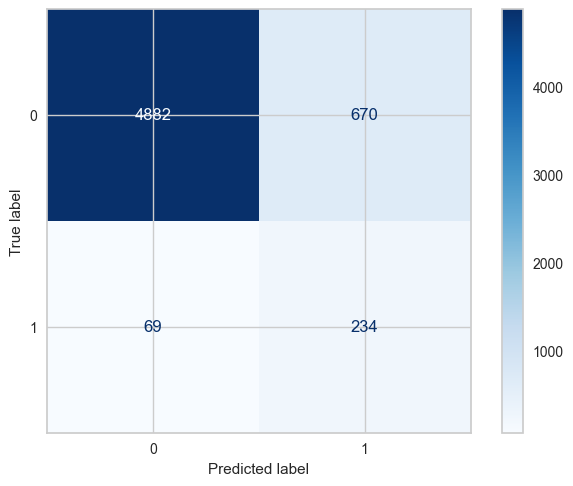

In [154]:
# Initialize the Gradient Boosting classifier
gbc_model = GradientBoostingClassifier()

# Train the model
gbc_model.fit(X_resampled_features_set_6, y_resampled)

# Predict on the test set
y_pred = gbc_model.predict(X_test_features_set_6)

# Evaluate the model
print(classification_report(y_test, y_pred, target_names=target_names))
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()

In [150]:
# Initialize and fit LazyClassifier
clf = LazyClassifier()
models, predictions = clf.fit(X_resampled_features_set_6, X_test_features_set_6, y_resampled, y_test)

# View the performance comparison
print(models)

 97%|█████████▋| 28/29 [01:40<00:02,  2.76s/it]

[LightGBM] [Info] Number of positive: 11380, number of negative: 9229
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004008 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 327
[LightGBM] [Info] Number of data points in the train set: 20609, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552186 -> initscore=0.209507
[LightGBM] [Info] Start training from score 0.209507


100%|██████████| 29/29 [01:41<00:00,  3.48s/it]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
LGBMClassifier                     0.89               0.80     0.80      0.91   
XGBClassifier                      0.89               0.79     0.79      0.91   
PassiveAggressiveClassifier        0.80               0.79     0.79      0.85   
SVC                                0.88               0.78     0.78      0.91   
LogisticRegression                 0.87               0.78     0.78      0.90   
LinearSVC                          0.87               0.78     0.78      0.90   
Perceptron                         0.84               0.77     0.77      0.88   
CalibratedClassifierCV             0.87               0.76     0.76      0.90   
AdaBoostClassifier                 0.87               0.76     0.76      0.90   
RidgeClassifierCV                  0.88               0.76     0.76      0.90   
RidgeClassifier             

In [151]:
# Load dataset and initialize PyCaret
clf = setup(data=pd.concat([data_cleaned_filtered_transformed[features_set_6], 
                            data_cleaned_filtered_transformed[['y']]], axis=1), 
            target='y')
# Compare models and select the best
best_model = compare_models()

# Tune the best model
tuned_model = tune_model(best_model)

,Description,Value
0,Session id,2467
1,Target,y
2,Target type,Binary
3,Original data shape,"(19515, 15)"
4,Transformed data shape,"(19515, 15)"
5,Transformed train set shape,"(13660, 15)"
6,Transformed test set shape,"(5855, 15)"
7,Numeric features,14
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.9518,0.9230,0.1909,0.6198,0.2891,0.2719,0.3243,1.0230
lightgbm,Light Gradient Boosting Machine,0.9511,0.9276,0.2667,0.5645,0.3587,0.3371,0.3644,0.4730
lr,Logistic Regression,0.9480,0.8984,0.1234,0.5062,0.1969,0.1804,0.2303,5.5430
ridge,Ridge Classifier,0.9478,0.8968,0.0000,0.0000,0.0000,0.0000,0.0000,0.0940
dummy,Dummy Classifier,0.9478,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0940
rf,Random Forest Classifier,0.9475,0.9081,0.1951,0.4835,0.2765,0.2548,0.2839,1.0970
svm,SVM - Linear Kernel,0.9470,0.6480,0.0422,0.2585,0.0664,0.0595,0.0829,0.3240
et,Extra Trees Classifier,0.9452,0.8847,0.2512,0.4504,0.3205,0.2947,0.3092,1.0010
ada,Ada Boost Classifier,0.9442,0.8989,0.1473,0.4199,0.2162,0.1940,0.2240,0.4490
knn,K Neighbors Classifier,0.9430,0.6650,0.0435,0.2312,0.0726,0.0578,0.0801,0.6950


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9553,0.9358,0.2254,0.7273,0.3441,0.3275,0.3892
1,0.9488,0.9148,0.1268,0.5294,0.2045,0.1882,0.2414
2,0.9495,0.9412,0.1549,0.5500,0.2418,0.2240,0.2735
3,0.9561,0.9193,0.2817,0.6897,0.4000,0.3813,0.4231
4,0.9524,0.8991,0.2113,0.6250,0.3158,0.2973,0.3452
5,0.9546,0.9226,0.2113,0.7143,0.3261,0.3097,0.3728
6,0.9561,0.9386,0.2394,0.7391,0.3617,0.3450,0.4051
7,0.9517,0.8961,0.2222,0.6154,0.3265,0.3072,0.3508
8,0.9502,0.9377,0.1250,0.6429,0.2093,0.1955,0.2688


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[LightGBM] [Info] Number of positive: 11380, number of negative: 9229
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 316
[LightGBM] [Info] Number of data points in the train set: 20609, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552186 -> initscore=0.209507
[LightGBM] [Info] Start training from score 0.209507
                 precision    recall  f1-score   support

Non-Subscribers       0.98      0.90      0.94      5552
    Subscribers       0.28      0.71      0.40       303

       accuracy                           0.89      5855
      macro avg       0.63      0.80      0.67      5855
   weighted avg       0.95      0.89      0.91      5855



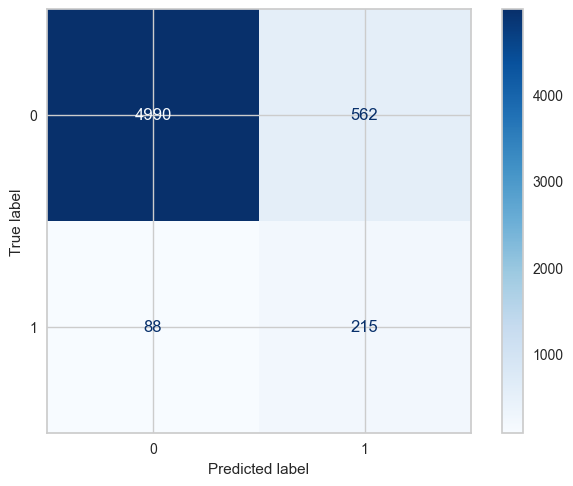

In [152]:
# Initialize the LightGBM classifie
lgbm_model = lgb.LGBMClassifier()

# Train the model
lgbm_model.fit(X_resampled_features_set_6, y_resampled)

# Predict on the test set
y_pred = lgbm_model.predict(X_test_features_set_6)[]

# Evaluate the model
print(classification_report(y_test, y_pred, target_names=target_names))
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()

Experimenting with feature set 7

In [26]:
features_set_7=['duration','day','month_mar','month_jun','age','month_jul','month_aug','balance','month_oct','month_feb','campaign','housing','month_may','education_tertiary']
# Select these features from X_resampled and X_test
X_resampled_features_set_7  = X_resampled[features_set_7]
X_test_features_set_7  = X_test[features_set_7]


                 precision    recall  f1-score   support

Non-Subscribers       0.99      0.84      0.91      5552
    Subscribers       0.22      0.80      0.34       303

       accuracy                           0.84      5855
      macro avg       0.60      0.82      0.62      5855
   weighted avg       0.95      0.84      0.88      5855



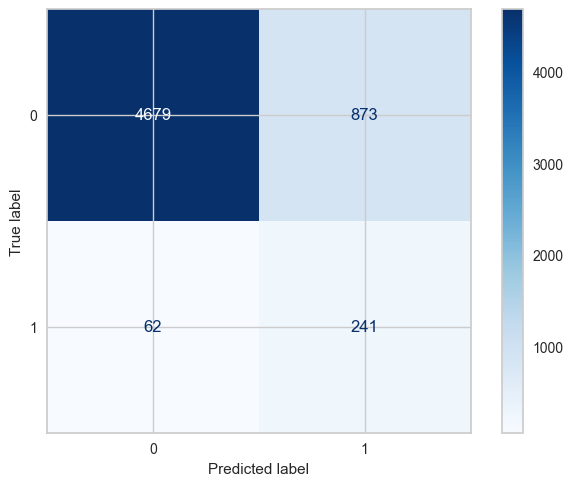

In [155]:
# Initialize the Gradient Boosting classifier
gbc_model = GradientBoostingClassifier()
# Train the model
gbc_model.fit(X_resampled_features_set_7, y_resampled)

# Predict on the test set
y_pred = gbc_model.predict(X_test_features_set_7)

# Evaluate the model
print(classification_report(y_test, y_pred, target_names=target_names))
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()

In [158]:
# Load dataset and initialize PyCaret
clf = setup(data=pd.concat([data_cleaned_filtered_transformed[features_set_7], 
                            data_cleaned_filtered_transformed[['y']]], axis=1), 
            target='y')
# Compare models and select the best
best_model = compare_models()

# Tune the best model
tuned_model = tune_model(best_model)

,Description,Value
0,Session id,5881
1,Target,y
2,Target type,Binary
3,Original data shape,"(19515, 15)"
4,Transformed data shape,"(19515, 15)"
5,Transformed train set shape,"(13660, 15)"
6,Transformed test set shape,"(5855, 15)"
7,Numeric features,14
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9536,0.9182,0.2777,0.6317,0.3839,0.3636,0.3979,0.5320
rf,Random Forest Classifier,0.9534,0.9092,0.2161,0.6620,0.3248,0.3072,0.3603,1.4720
gbc,Gradient Boosting Classifier,0.9524,0.9162,0.2218,0.6325,0.3264,0.3077,0.3546,1.3220
et,Extra Trees Classifier,0.9510,0.9078,0.2119,0.5830,0.3097,0.2901,0.3311,1.1930
ada,Ada Boost Classifier,0.9501,0.8967,0.1923,0.5774,0.2866,0.2673,0.3124,0.4540
lr,Logistic Regression,0.9490,0.8941,0.1362,0.5641,0.2169,0.2006,0.2575,4.7300
ridge,Ridge Classifier,0.9490,0.8917,0.0617,0.6679,0.1117,0.1034,0.1888,0.0820
dummy,Dummy Classifier,0.9478,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0770
qda,Quadratic Discriminant Analysis,0.9451,0.8784,0.1853,0.4429,0.2596,0.2362,0.2613,0.0590
nb,Naive Bayes,0.9446,0.8419,0.1811,0.4316,0.2538,0.2301,0.2543,0.0520


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9561,0.9176,0.1806,0.9286,0.3023,0.2901,0.3989
1,0.9510,0.9420,0.2222,0.5926,0.3232,0.3032,0.3431
2,0.9458,0.9255,0.1111,0.4444,0.1778,0.1601,0.2026
3,0.9539,0.8975,0.1972,0.7000,0.3077,0.2915,0.3559
4,0.9524,0.9005,0.2113,0.6250,0.3158,0.2973,0.3452
5,0.9590,0.9248,0.2676,0.8261,0.4043,0.3887,0.4564
6,0.9488,0.8835,0.1408,0.5263,0.2222,0.2048,0.2538
7,0.9524,0.9291,0.1690,0.6667,0.2697,0.2540,0.3200
8,0.9436,0.8702,0.1972,0.4118,0.2667,0.2411,0.2590


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [160]:
best_model

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=5881, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [157]:
# Initialize and fit LazyClassifier
clf = LazyClassifier()
models, predictions = clf.fit(X_resampled_features_set_7, X_test_features_set_7, y_resampled, y_test)

# View the performance comparison
print(models)

 97%|█████████▋| 28/29 [01:54<00:06,  6.51s/it]

[LightGBM] [Info] Number of positive: 11380, number of negative: 9229
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004810 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 629
[LightGBM] [Info] Number of data points in the train set: 20609, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552186 -> initscore=0.209507
[LightGBM] [Info] Start training from score 0.209507


100%|██████████| 29/29 [01:55<00:00,  3.98s/it]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
LGBMClassifier                     0.86               0.81     0.81      0.89   
SVC                                0.83               0.80     0.80      0.88   
XGBClassifier                      0.88               0.79     0.79      0.90   
AdaBoostClassifier                 0.84               0.79     0.79      0.88   
RandomForestClassifier             0.88               0.79     0.79      0.91   
SGDClassifier                      0.82               0.77     0.77      0.86   
LogisticRegression                 0.81               0.77     0.77      0.86   
CalibratedClassifierCV             0.81               0.77     0.77      0.86   
LinearSVC                          0.81               0.77     0.77      0.86   
ExtraTreesClassifier               0.89               0.77     0.77      0.91   
KNeighborsClassifier        

[LightGBM] [Info] Number of positive: 11380, number of negative: 9229
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002808 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 620
[LightGBM] [Info] Number of data points in the train set: 20609, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552186 -> initscore=0.209507
[LightGBM] [Info] Start training from score 0.209507
                 precision    recall  f1-score   support

Non-Subscribers       0.99      0.87      0.92      5552
    Subscribers       0.24      0.77      0.37       303

       accuracy                           0.86      5855
      macro avg       0.61      0.82      0.65      5855
   weighted avg       0.95      0.86      0.90      5855



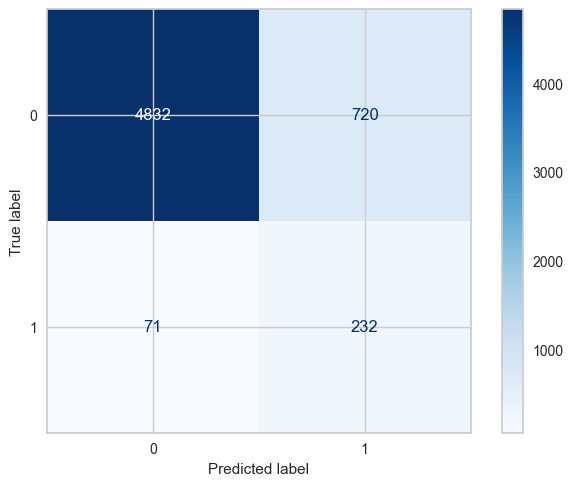

In [161]:
# Initialize the LightGBM classifier
lgbm_model = lgb.LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=5881, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

# Train the model
lgbm_model.fit(X_resampled_features_set_7, y_resampled)

# Predict on the test set
y_pred = lgbm_model.predict(X_test_features_set_7)

# Evaluate the model
print(classification_report(y_test, y_pred, target_names=target_names))
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()

<b> Outcome of Experiment <b>

The outcome of the experiment was that feature set 7 is better than other feature sets. GBC Model on the (smote-enn) resampled data using feature set 7 had the best performance. 
<br>
Therefore further work will be done on data where the features are in feature set 3 and the training data is resampled using SMOTE-ENN.

In [139]:
from tpot import TPOTClassifier

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9933783524895763

Generation 2 - Current best internal CV score: 0.9933783524895763

Generation 3 - Current best internal CV score: 0.9933783524895763

Generation 4 - Current best internal CV score: 0.9956754484554405

Generation 5 - Current best internal CV score: 0.9956754484554405

Best pipeline: GradientBoostingClassifier(input_matrix, learning_rate=0.5, max_depth=9, max_features=1.0, min_samples_leaf=12, min_samples_split=17, n_estimators=100, subsample=0.8)
              precision    recall  f1-score   support

           0       0.98      0.90      0.94      5552
           1       0.26      0.64      0.37       303

    accuracy                           0.89      5855
   macro avg       0.62      0.77      0.65      5855
weighted avg       0.94      0.89      0.91      5855



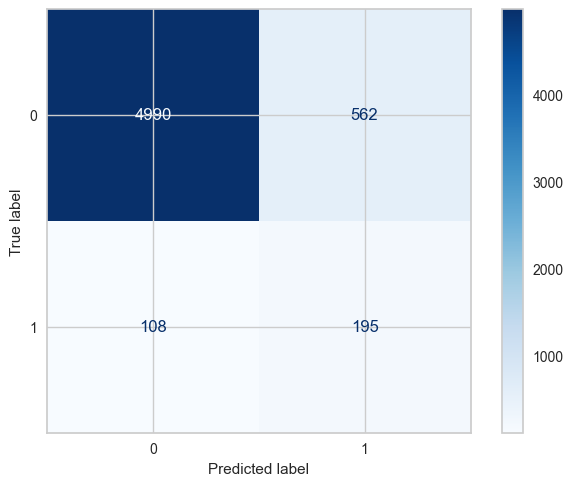

In [162]:
# Initialize the TPOTClassifier
tpot = TPOTClassifier(verbosity=2, generations=5, population_size=20, random_state=42, scoring='roc_auc')

# Fit the model
tpot.fit(X_resampled_features_set_7, y_resampled)

# Predict on the test set
y_pred = tpot.predict(X_test_features_set_7)

# Evaluate the model
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9836341225816982

Generation 2 - Current best internal CV score: 0.98363547592595

Generation 3 - Current best internal CV score: 0.98363547592595

Generation 4 - Current best internal CV score: 0.9839507047207234

Generation 5 - Current best internal CV score: 0.9839507047207234

Best pipeline: GradientBoostingClassifier(input_matrix, learning_rate=0.1, max_depth=6, max_features=0.4, min_samples_leaf=18, min_samples_split=19, n_estimators=100, subsample=0.6500000000000001)
              precision    recall  f1-score   support

           0       0.98      0.87      0.92      5552
           1       0.23      0.74      0.35       303

    accuracy                           0.86      5855
   macro avg       0.61      0.80      0.64      5855
weighted avg       0.95      0.86      0.89      5855



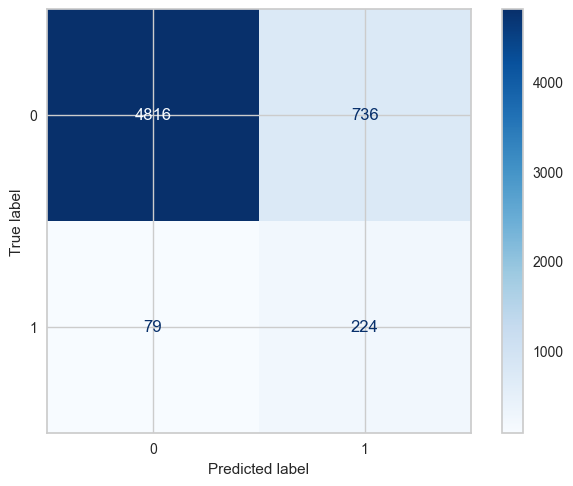

In [140]:
# Initialize the TPOTClassifier
tpot = TPOTClassifier(verbosity=2, generations=5, population_size=20, random_state=42, scoring='roc_auc')

# Fit the model
tpot.fit(X_resampled_features_set_3, y_resampled)

# Predict on the test set
y_pred = tpot.predict(X_test_features_set_3)

# Evaluate the model
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()

TPOT-Best Accuracy

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9265858319554956

Generation 2 - Current best internal CV score: 0.9267313805891906

Generation 3 - Current best internal CV score: 0.9267313805891906

Generation 4 - Current best internal CV score: 0.9272651727268564

Generation 5 - Current best internal CV score: 0.9273622247724435

Best pipeline: RandomForestClassifier(RobustScaler(ZeroCount(input_matrix)), bootstrap=False, criterion=entropy, max_features=0.2, min_samples_leaf=20, min_samples_split=19, n_estimators=100)
              precision    recall  f1-score   support

           0       0.98      0.87      0.92      5552
           1       0.23      0.70      0.35       303

    accuracy                           0.86      5855
   macro avg       0.61      0.79      0.64      5855
weighted avg       0.94      0.86      0.89      5855



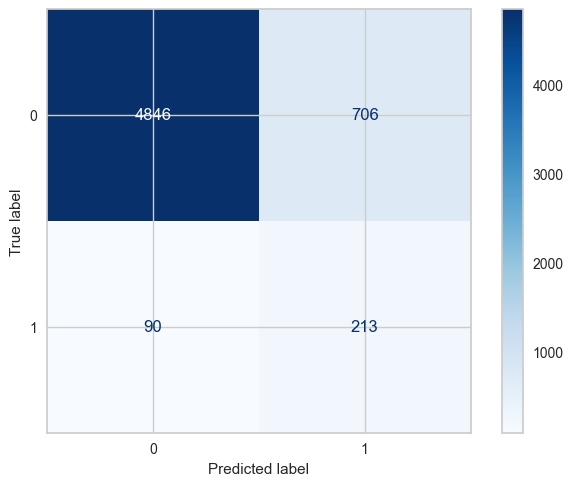

In [102]:


# Initialize the TPOTClassifier
tpot = TPOTClassifier(verbosity=2, generations=5, population_size=20, random_state=42)

# Fit the model
tpot.fit(X_resampled_features_set_1, y_resampled)

# Predict on the test set
y_pred = tpot.predict(X_test_features_set_1)

# Evaluate the model
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()

TPOT-Recall

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 1.0

Generation 2 - Current best internal CV score: 1.0

Generation 3 - Current best internal CV score: 1.0

Generation 4 - Current best internal CV score: 1.0

Generation 5 - Current best internal CV score: 1.0

Best pipeline: MLPClassifier(input_matrix, alpha=0.1, learning_rate_init=1.0)
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5552
           1       0.05      1.00      0.10       303

    accuracy                           0.05      5855
   macro avg       0.03      0.50      0.05      5855
weighted avg       0.00      0.05      0.01      5855



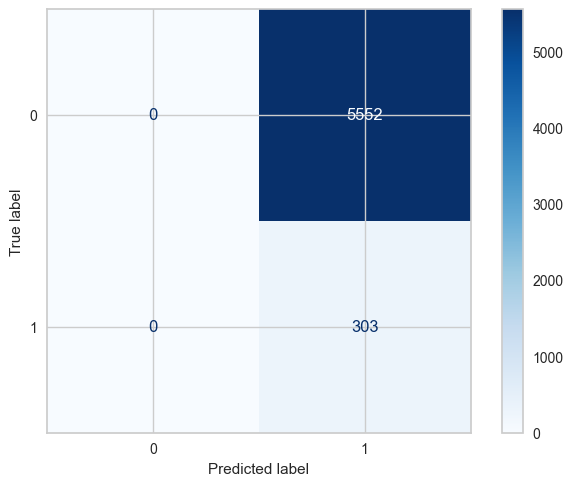

In [103]:
# Initialize the TPOTClassifier
tpot = TPOTClassifier(verbosity=2, generations=5, population_size=20, random_state=42, scoring='recall')

# Fit the model
tpot.fit(X_resampled_features_set_1, y_resampled)

# Predict on the test set
y_pred = tpot.predict(X_test_features_set_1)

# Evaluate the model
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9334054209939169

Generation 2 - Current best internal CV score: 0.9334054209939169

Generation 3 - Current best internal CV score: 0.9334054209939169

Generation 4 - Current best internal CV score: 0.933602501960911

Generation 5 - Current best internal CV score: 0.933723439181049

Best pipeline: RandomForestClassifier(StandardScaler(input_matrix), bootstrap=False, criterion=entropy, max_features=0.2, min_samples_leaf=8, min_samples_split=19, n_estimators=100)
              precision    recall  f1-score   support

           0       0.98      0.87      0.92      5552
           1       0.23      0.71      0.34       303

    accuracy                           0.86      5855
   macro avg       0.60      0.79      0.63      5855
weighted avg       0.94      0.86      0.89      5855



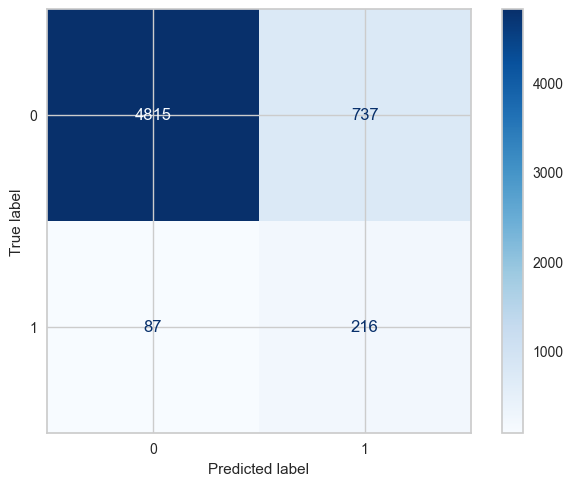

In [104]:
# Initialize the TPOTClassifier
tpot = TPOTClassifier(verbosity=2, generations=5, population_size=20, random_state=42, scoring='f1')

# Fit the model
tpot.fit(X_resampled_features_set_1, y_resampled)

# Predict on the test set
y_pred = tpot.predict(X_test_features_set_1)

# Evaluate the model
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9763456078282257

Generation 2 - Current best internal CV score: 0.9765949799282488

Generation 3 - Current best internal CV score: 0.9765949799282488

Generation 4 - Current best internal CV score: 0.9765949799282488

Generation 5 - Current best internal CV score: 0.9767062697884412

Best pipeline: RandomForestClassifier(MinMaxScaler(input_matrix), bootstrap=True, criterion=gini, max_features=0.2, min_samples_leaf=14, min_samples_split=4, n_estimators=100)
              precision    recall  f1-score   support

           0       0.98      0.87      0.92      5552
           1       0.23      0.71      0.34       303

    accuracy                           0.86      5855
   macro avg       0.60      0.79      0.63      5855
weighted avg       0.94      0.86      0.89      5855



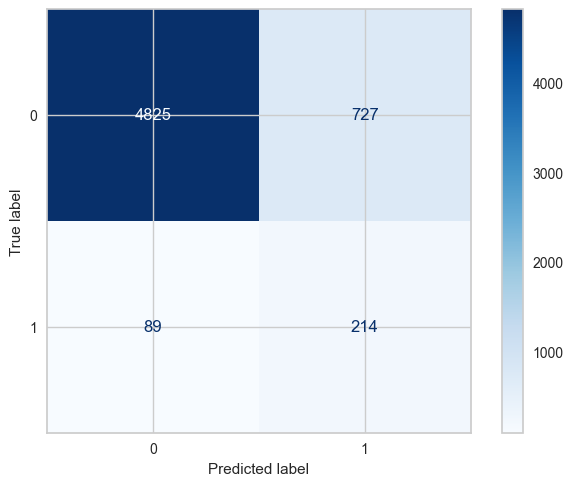

In [105]:
# Initialize the TPOTClassifier
tpot = TPOTClassifier(verbosity=2, generations=5, population_size=20, random_state=42, scoring='roc_auc')

# Fit the model
tpot.fit(X_resampled_features_set_1, y_resampled)

# Predict on the test set
y_pred = tpot.predict(X_test_features_set_1)

# Evaluate the model
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9311482276982744

Generation 2 - Current best internal CV score: 0.9322684907182562

Generation 3 - Current best internal CV score: 0.9361557050740622

Generation 4 - Current best internal CV score: 0.9404615298355001

Generation 5 - Current best internal CV score: 0.9569576144801182

Best pipeline: BernoulliNB(StandardScaler(ZeroCount(input_matrix)), alpha=10.0, fit_prior=False)
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      5552
           1       0.31      0.34      0.33       303

    accuracy                           0.93      5855
   macro avg       0.64      0.65      0.64      5855
weighted avg       0.93      0.93      0.93      5855



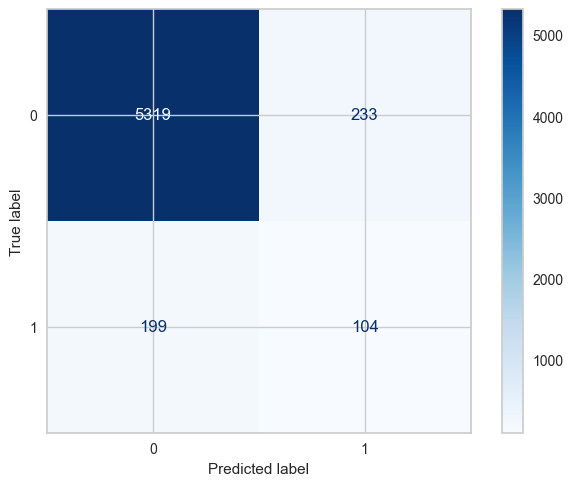

In [106]:
# Initialize the TPOTClassifier
tpot = TPOTClassifier(verbosity=2, generations=5, population_size=20, random_state=42, scoring='precision')

# Fit the model
tpot.fit(X_resampled_features_set_1, y_resampled)

# Predict on the test set
y_pred = tpot.predict(X_test_features_set_1)

# Evaluate the model
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9807349648537252

Generation 2 - Current best internal CV score: 0.9807349648537252

Generation 3 - Current best internal CV score: 0.9807349648537252

Generation 4 - Current best internal CV score: 0.9848804211665376

Generation 5 - Current best internal CV score: 0.9863775160311908

Best pipeline: KNeighborsClassifier(ZeroCount(input_matrix), n_neighbors=3, p=2, weights=distance)
              precision    recall  f1-score   support

           0       0.97      0.76      0.85      5552
           1       0.10      0.50      0.17       303

    accuracy                           0.75      5855
   macro avg       0.53      0.63      0.51      5855
weighted avg       0.92      0.75      0.82      5855



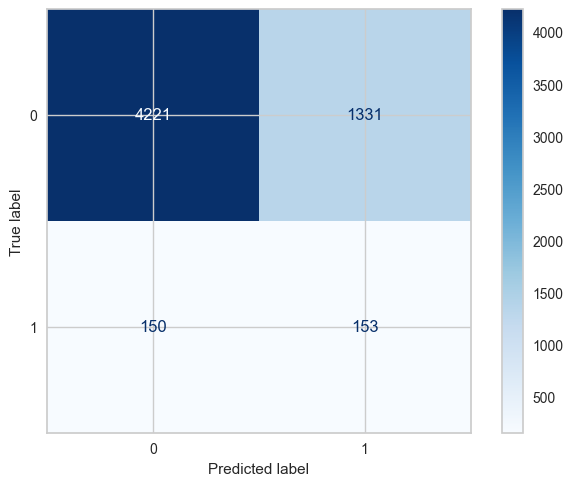

In [108]:
# Initialize the TPOTClassifier
tpot = TPOTClassifier(verbosity=2, generations=5, population_size=20, random_state=42, scoring='f1')

# Fit the model
tpot.fit(X_resampled, y_resampled)

# Predict on the test set
y_pred = tpot.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()

<b> Tuning the best model with Optuna <b>

So we can already see that we are getting a pretty decent recall for class 1 with GBC model on feature set 7. Now to make this even better we need to see if we can increase the precision.

Optuna to maximize precision while constraining recall for subscribers to be >=80%

In [171]:
import optuna
from sklearn.metrics import classification_report, precision_score, recall_score

# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 2, 10)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.1)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)

    # Initialize the Gradient Boosting classifier with suggested hyperparameters
    gbc_model = GradientBoostingClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf
    )
    
    # Fit the model on the resampled training data
    gbc_model.fit(X_resampled_features_set_7, y_resampled)
    
    # Predict on the test set
    y_pred = gbc_model.predict(X_test_features_set_7)
    
    # Get precision and recall for class 1 (subscribers)
    precision_class1 = precision_score(y_test, y_pred, pos_label=1)
    recall_class1 = recall_score(y_test, y_pred, pos_label=1)
    
    # Only consider trials where recall for class 1 is >= 80%
    if recall_class1 >= 0.80:
        return precision_class1
    else:
        return 0  # Assign a low score to discard this trial

# Create an Optuna study to maximize precision for class 1
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Print the best trial
print(f'Best trial: {study.best_trial.params}')


[I 2024-10-04 14:52:38,053] A new study created in memory with name: no-name-6f8d65e3-5a00-455a-b409-8a26e3839760
[I 2024-10-04 14:53:06,564] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 175, 'max_depth': 9, 'learning_rate': 0.00935525960446066, 'min_samples_split': 13, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.0.
[I 2024-10-04 14:53:37,124] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 357, 'max_depth': 7, 'learning_rate': 0.06375256914416755, 'min_samples_split': 14, 'min_samples_leaf': 20}. Best is trial 0 with value: 0.0.
[I 2024-10-04 14:54:08,975] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 365, 'max_depth': 7, 'learning_rate': 0.020415069683690997, 'min_samples_split': 3, 'min_samples_leaf': 17}. Best is trial 0 with value: 0.0.
[I 2024-10-04 14:54:22,447] Trial 3 finished with value: 0.17409184372858122 and parameters: {'n_estimators': 171, 'max_depth': 6, 'learning_rate': 0.003895132948715162, 'min_sam

Best trial: {'n_estimators': 225, 'max_depth': 5, 'learning_rate': 0.06506520090536456, 'min_samples_split': 13, 'min_samples_leaf': 11}


                 precision    recall  f1-score   support

Non-Subscribers       0.99      0.87      0.92      5552
    Subscribers       0.25      0.80      0.38       303

       accuracy                           0.86      5855
      macro avg       0.62      0.83      0.65      5855
   weighted avg       0.95      0.86      0.90      5855



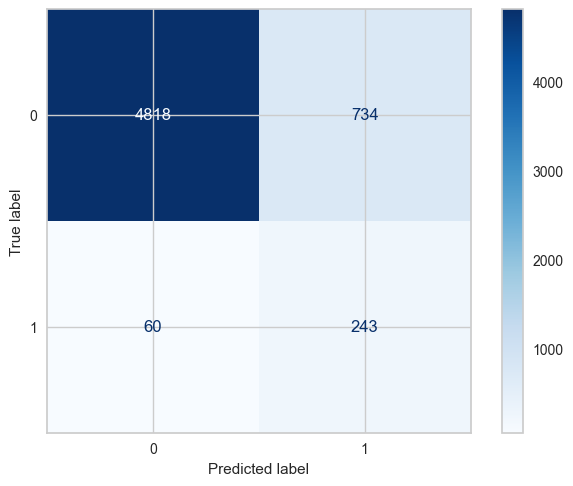

In [175]:
# Initialize the Gradient Boosting classifier
gbc_model = GradientBoostingClassifier(n_estimators=225, 
                                       max_depth=5, 
                                       learning_rate=0.06506520090536456, 
                                       min_samples_split=13, 
                                       min_samples_leaf=11)# Train the model
gbc_model.fit(X_resampled_features_set_7, y_resampled)

# Predict on the test set
y_pred = gbc_model.predict(X_test_features_set_7)

# Evaluate the model
print(classification_report(y_test, y_pred, target_names=target_names))
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()

Above we can see that we got a marginal improvement from the original GBC model performance of 80% recall, 22% precision...now we have 25% precision.

Testing the model on the original 40K data

In [5]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

data_transformed=data.copy()

# Columns to label encode
label_encode_cols = ['marital', 'contact']

# Apply label encoding to marital and contact
for col in label_encode_cols:
    data_transformed[col] = label_encoder.fit_transform(data_transformed[col])

# Columns to one-hot encode
one_hot_encode_cols = ['job', 'education', 'month']

# Apply one-hot encoding to job, education, and month
data_transformed = pd.get_dummies(data_transformed, columns=one_hot_encode_cols, drop_first=True)

# Identify the one-hot encoded columns (boolean columns)
one_hot_cols = data_transformed.filter(like='_').columns

# Convert True/False to 1/0 for the one-hot encoded columns
data_transformed[one_hot_cols] = data_transformed[one_hot_cols].astype(int)

# Check the transformed dataset
data_transformed.head()


,age,marital,default,balance,housing,loan,contact,day,duration,campaign,...,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct
0,58,1,no,2143,yes,no,2,5,261,1,...,0,0,0,0,0,0,0,1,0,0
1,44,2,no,29,yes,no,2,5,151,1,...,0,0,0,0,0,0,0,1,0,0
2,33,1,no,2,yes,yes,2,5,76,1,...,0,0,0,0,0,0,0,1,0,0
3,47,1,no,1506,yes,no,2,5,92,1,...,0,0,0,0,0,0,0,1,0,0
4,33,2,no,1,no,no,2,5,198,1,...,0,0,0,0,0,0,0,1,0,0


In [7]:
# Convert 'yes' to 1 and 'no' to 0 in binary features
for col in binary_features:
    data_transformed[col] = data_transformed[col].map({'yes': 1, 'no': 0})

# Check the transformed dataset
data_transformed.head()

,age,marital,default,balance,housing,loan,contact,day,duration,campaign,...,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct
0,58,1,0,2143,1,0,2,5,261,1,...,0,0,0,0,0,0,0,1,0,0
1,44,2,0,29,1,0,2,5,151,1,...,0,0,0,0,0,0,0,1,0,0
2,33,1,0,2,1,1,2,5,76,1,...,0,0,0,0,0,0,0,1,0,0
3,47,1,0,1506,1,0,2,5,92,1,...,0,0,0,0,0,0,0,1,0,0
4,33,2,0,1,0,0,2,5,198,1,...,0,0,0,0,0,0,0,1,0,0


In [9]:
# Convert 'y' to binary values (1 for 'yes', 0 for 'no') and avoid SettingWithCopyWarning
data_transformed.loc[:, 'y'] = data_transformed['y'].map({'yes': 1, 'no': 0}).astype(int)

In [13]:
# Convert 'y' to integer type
data_transformed['y'] = data_transformed['y'].astype(int)
y_test_raw_data= data_transformed['y']
X_test_raw_data = data_transformed.drop(['y'],axis=1)

X_test_raw_data_feature_set_7=X_test_raw_data[features_set_7]



                 precision    recall  f1-score   support

Non-Subscribers       0.98      0.81      0.89     37104
    Subscribers       0.25      0.80      0.38      2896

       accuracy                           0.81     40000
      macro avg       0.61      0.80      0.63     40000
   weighted avg       0.93      0.81      0.85     40000



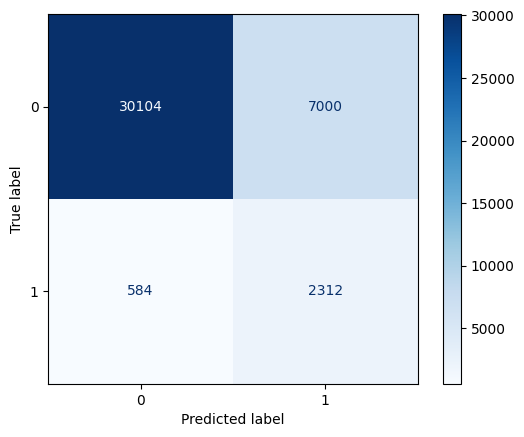

In [30]:
# Initialize the Gradient Boosting classifier
gbc_model = GradientBoostingClassifier(n_estimators=225, 
                                       max_depth=5, 
                                       learning_rate=0.06506520090536456, 
                                       min_samples_split=13, 
                                       min_samples_leaf=11)# Train the model
gbc_model.fit(X_resampled_features_set_7, y_resampled)

# Predict on the test set
y_pred_raw_data = gbc_model.predict(X_test_raw_data_feature_set_7)

# Evaluate the model
print(classification_report(y_test_raw_data, y_pred_raw_data, target_names=target_names))
cm = confusion_matrix(y_test_raw_data, y_pred_raw_data)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()

This is a very exciting outcome. Above we can see the model performance when run on the original raw 40,000 calls data. This means if this model is used the company can make calls only to those people which the model predicts to be as subscribers. This would reduce the calls made from 40,000 to 9,312 and it would still capture 80% of the subscribers in those 9,312 calls. 

<b> Calculating hours saved <b>

Time spent in making 40,000 calls

In [31]:
original_total_duration = data_transformed['duration'].sum()
print(original_total_duration)


10192972


Original duration is: 2831.38 hours

Time spent calling those people who the model predicts to be subscribers (9,312 calls)

In [32]:
# Convert y_pred_raw_data to a boolean mask where predictions are 1 (subscribers)
subscriber_mask = (y_pred_raw_data == 1)

# Filter X_test_raw_data_feature_set_7 based on the mask and sum the "duration" column
total_duration_for_subscribers = X_test_raw_data_feature_set_7[subscriber_mask]['duration'].sum()

print(total_duration_for_subscribers)


4746102


New durations is: 1318.36 hours

Hours saved: 1513 hours